# Development of a NLP-inspired descriptor for solid solutions

This notebook is divided into four main sections:
- [generate all the symmetry irreducible structures by reading a CRYSTAL confcount output](#generate)
- [build the descriptor](#descriptor)
- [build the new descriptor](#new_descriptor)
- [test other descriptors](#other_descriptors)
- [run the ML analysis](#ml)
- [write CRYSTAL input files and analyse CRYSTAL output files](#crystal)
- [write CRYSTAL input files and analyse CRYSTAL output files LTS](#crystal_lts)
- [extract the output info](#extract_info)
- [geometry optimisation](#geometry_opt)
- [the functions](#functions)






#### Possible descriptors:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- neighbours_spatial_dist_all_sorted: like neighbours_spatial_dist_all, but storted row-sorted
- neighbours_spatial_dist_all_sorted_sliced: like neighbours_spatial_dist_all_sorted, but without the central atom number
- neighbours_spatial_dist_all_sorted_sliced_flat: like neighbours_spatial_dist_all_sorted, but without the central atom number, but as a flat array
- neighbours_spatial_dist_all_sorted_sliced_sum: like neighbours_spatial_dist_all_sorted_sliced, but summed columnwise


In [2]:
import sys
sys.path.insert(1, '/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')

from crystal_io import *
from convert import *
from execute import *
'''from CRYSTALpytools.crystal_io import Crystal_output, Crystal_input, Crystal_density, Crystal_gui
from CRYSTALpytools.convert import cry_gui2pmg, cry_out2pmg
from CRYSTALpytools.utils import view_pmg
from CRYSTALpytools.calculate import cry_shrink
'''
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.core.surface import SlabGenerator
import numpy as np
import pandas as pd
import os
from pathlib import Path
import copy
import itertools
import shutil as sh

from pymatgen.ext.matproj import MPRester
import json
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.cluster import KMeans

#from dscribe.descriptors import CoulombMatrix

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

# <a id='generate'>Generate all the symmetry irreducible structures</a>

## CaMgO

In [6]:
new_atom = 'Mg'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/cao_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_mco = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type1):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_mco.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())


## LTS

In [114]:
new_atom = 'Li'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/lts/lts_confcount.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/lts/lts_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_lts = []
li_atoms = []
ti_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_lts.append(new_structure)
    ti_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    li_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())


In [116]:
structures = copy.deepcopy(structures_lts)

# <a id='descriptor'>The descriptor</a> - The magic happens here

Each element of the neighbours_spatial_dist_all (one element per structure) is a 2D array whose rows correspond to an atom and the array contains:
- 0 = atom number of the atom whose neighbours I'm analysing
- 1:6 = atomic numbers of the atoms in the first coord shell
- 7:19 = atomic numbers of the atoms in the second coord shell
- 20:28 = atomic numbers of the atoms in the third coord shell

These atomic numbers are ordered following a spatial analysis. They are written starting from the atoms below the atom 0 and moving upwards.

## Spatial distribution analysis

### Shells

In [94]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
shells

[0.0, 2.54275, 3.595992, 4.404172, 5.0855, 5.685762, 6.22844, 7.62825]

In [178]:
#SAVE
max_shell = 6
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
shells_norm = copy.deepcopy(shells)
shells_norm[0] = 1.0
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for m,n in enumerate(range(max_shell+1)):
            centered_sph_coords = []
            
            #atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            neighbours = structure.get_neighbors_in_shell(structure.sites[j].coords,shells[n],0.2)
            #print(len(neighbours))
            new_cart_coords = [x.coords.tolist() for x in neighbours]
            atom_numbers = [int(x.specie.number) for x in neighbours]
            #print(atom_numbers)
            centered_cart_coords = np.array(new_cart_coords)-structure.cart_coords[j]
            centered_sph_coords = cart2sph_array(centered_cart_coords)
            
            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,2])
            #the_d = np.array(centered_sph_coords)[:,1]*10 +\
                                              #np.array(centered_sph_coords)[:,2]
            #print((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            
            #SORT DESCRIPTOR
            #neighbours_spatial_dist_atom.extend(np.sort(np.array(atom_numbers)))
            
            neighbours_spatial_dist_atom.extend((np.array(atom_numbers)[spatial_distribution]).tolist())
            #neighbours_spatial_dist_atom.extend((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            #neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)  
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)        

In [178]:
#OLD
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
max_shell = 5
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for n in range(max_shell+1):
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:
                
                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        
            #print(centered_sph_coords)
            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,2])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)        

NameError: name 'cart2sph' is not defined

### pymatgen.analysis.local_env

In [65]:
'''from pymatgen.analysis.local_env import NearNeighbors
cnn = CrystalNN() # using default params

N = 0 # Site of interest, can be anything in [0, num_sites - 1]
info = cnn.get_nn_info(structure,0)
info'''

[{'site': PeriodicSite: O (-2.4191, 0.0000, 0.0000) [0.2500, -0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 11},
 {'site': PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.2500, 0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 12},
 {'site': PeriodicSite: O (0.0000, -2.4191, 0.0000) [-0.2500, 0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 13},
 {'site': PeriodicSite: O (0.0000, 0.0000, 2.4191) [0.2500, 0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 9},
 {'site': PeriodicSite: O (0.0000, 0.0000, -2.4191) [-0.2500, -0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 14},
 {'site': PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.2500, -0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 10}]

In [262]:
'''for site in structures[0].sites:
    #print(site.coords)
    neighbours = structures[0].get_neighbors_in_shell(site.coords,shells[1],0.2) 
    print([x.coords for x in neighbours])'''

'for site in structures[0].sites:\n    #print(site.coords)\n    neighbours = structures[0].get_neighbors_in_shell(site.coords,shells[1],0.2) \n    print([x.coords for x in neighbours])'

In [263]:
'''from pymatgen.analysis.local_env import NearNeighbors
cnn = CrystalNN() # using default params

N = 0 # Site of interest, can be anything in [0, num_sites - 1]
numbers = []
positions = []
info = cnn.get_nn_shell_info(structure, 0,4)
for i, site in enumerate(info):
    #print(structures[0].get_distance(N, site['site_index']),site['site_index'])
    print(site['site'].specie.number,site['site'].coords)
    numbers.append(site['site'].specie.number)
    positions.append(site['site'].coords)
cell = np.eye(3)*10.
vview(Structure(cell,numbers, positions,coords_are_cartesian=False))'''

"from pymatgen.analysis.local_env import NearNeighbors\ncnn = CrystalNN() # using default params\n\nN = 0 # Site of interest, can be anything in [0, num_sites - 1]\nnumbers = []\npositions = []\ninfo = cnn.get_nn_shell_info(structure, 0,4)\nfor i, site in enumerate(info):\n    #print(structures[0].get_distance(N, site['site_index']),site['site_index'])\n    print(site['site'].specie.number,site['site'].coords)\n    numbers.append(site['site'].specie.number)\n    positions.append(site['site'].coords)\ncell = np.eye(3)*10.\nvview(Structure(cell,numbers, positions,coords_are_cartesian=False))"

## Save pre-descriptor to file

In [179]:
neighbours_spatial_dist_all_json = json.dumps(list(neighbours_spatial_dist_all))
jsonFile = open('data/ml/lts_neighbours_spatial_dist_all_6.json', "w")
jsonFile.write(neighbours_spatial_dist_all_json)
jsonFile.close()

## Read pre-descriptor from file

In [25]:
with open('data/ml/lneighbours_spatial_dist_all_.json') as file:
    neighbours_spatial_dist_all = json.load(file)
neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

In [27]:
#ALL AT ONCE
with open('data/ml/neighbours_spatial_dist_all_4.json') as file:
    neighbours_spatial_dist_all = json.load(file)
neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)


neighbours_spatial_dist_all_sorted = []
sorting = []

for k,structure in enumerate(range(neighbours_spatial_dist_all.shape[0])):
    sorted_atoms = []
    for i in range(neighbours_spatial_dist_all.shape[1]):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    sorting.append(np.argsort(np.array(sorted_atoms))) 
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)   

'''#################################### Normalise by distance ######################################
unique = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[0]
num_unique = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[1]

distance_norm = [1]
for i,dist in enumerate(unique[1:]):
    #distance_norm.extend([np.exp(1/dist**2)]*num_unique[i])
    distance_norm.extend([(1/dist**2)]*num_unique[i])
distance_norm = distance_norm[0:neighbours_spatial_dist_all.shape[2]]

neighbours_spatial_dist_all_sorted = neighbours_spatial_dist_all_sorted*distance_norm
#################################### Normalise by distance ######################################'''

neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
neighbours_spatial_dist_all_sorted_sliced_flat = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])

neighbours_spatial_dist_all_sorted_sliced_reduced = \
neighbours_spatial_dist_all_sorted_sliced[neighbours_spatial_dist_all_sorted_sliced != 8]

vector_len = int(neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures)

neighbours_spatial_dist_all_sorted_sliced_reduced = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced_reduced,[n_structures,vector_len])

In [31]:
descriptor_4 = neighbours_spatial_dist_all_sorted_sliced_reduced

In [343]:
neigh_count = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[1]
elements_shell = neigh_count[1:5]*27

In [344]:
neighbours_spatial_dist_all_sorted_sliced_flat2 = []
neigh_count = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[1]
neigh_count[0] = 0
neigh_count = np.cumsum(neigh_count)
#print((neigh_count))


for line in range(len(structures[0:4])):
    #print('Structure %s'%str(line))
    neighbours_spatial_dist_all_sorted_sliced_flat2_tmp = []
    for i in range(1,6):
        #print(neigh_count[(i-1)],neigh_count[i])
        flat_tmp = neighbours_spatial_dist_all_sorted_sliced[line,:,neigh_count[(i-1)]:neigh_count[i]].flatten()
        #print(len(flat_tmp))

        flat_tmp = flat_tmp[flat_tmp != 8]
        #print(len(flat_tmp))
        
        neighbours_spatial_dist_all_sorted_sliced_flat2_tmp.extend(flat_tmp)
    neighbours_spatial_dist_all_sorted_sliced_flat2.append(neighbours_spatial_dist_all_sorted_sliced_flat2_tmp)
neighbours_spatial_dist_all_sorted_sliced_flat2 = np.array(neighbours_spatial_dist_all_sorted_sliced_flat2)

In [221]:
unique = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[0]
num_unique = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[1]

distance_norm = [1]
for i,dist in enumerate(unique[1:]):
    #distance_norm.extend([np.exp(1/dist**2)]*num_unique[i])
    distance_norm.extend([(1/dist**2)]*num_unique[i])
distance_norm = distance_norm[0:neighbours_spatial_dist_all.shape[2]]

neighbours_spatial_dist_all_sorted = neighbours_spatial_dist_all_sorted*distance_norm

In [223]:
num_unique

array([ 1,  6, 12,  8,  6, 12,  8,  1])

## Make binary

In [345]:
descriptor_4_2 = neighbours_spatial_dist_all_sorted_sliced_flat2

In [368]:
descriptor_4_bin = []
for line in descriptor_4:
    descriptor_4_bin.append(build_discrete_vector(line,num_species=2))
descriptor_4_bin = np.array(descriptor_4_bin,dtype=float)

In [372]:
scaling = 2
neigh_count = np.unique(np.sort(np.round(structures[0].distance_matrix[0],5)),return_counts=True)[1]
elements_shell = neigh_count[1:5]*54
elements_shell = np.cumsum(elements_shell)
elements_shell = np.insert(elements_shell,0,0)
print(elements_shell)
for i in range(1,len(elements_shell)):
    scaling /= 2
    descriptor_4_bin[:,elements_shell[i-1]:elements_shell[i]] = descriptor_4_bin[:,elements_shell[i-1]:elements_shell[i]]*scaling

[   0  324  972 1404 1728]


### Save the descriptor to file

In [85]:
neighbours_spatial_dist_all_sorted_sliced_reduced_json = \
                json.dumps(neighbours_spatial_dist_all_sorted_sliced_reduced.tolist())
jsonFile = open('data/classification/ml/descriptor_4.json', "w")
jsonFile.write(neighbours_spatial_dist_all_sorted_sliced_reduced_json)
jsonFile.close()
descriptor_4 = neighbours_spatial_dist_all_sorted_sliced_reduced_json

### Read the descriptor from file

In [45]:
with open('data/classification/ml/descriptor_4.json') as file:
    descriptor_4 = json.load(file)
descriptor_4 = np.array(descriptor_4)

### Sort by first atom

In [37]:
neighbours_spatial_dist_all_sorted = []
sorting = []

for k,structure in enumerate(range(neighbours_spatial_dist_all.shape[0])):
    sorted_atoms = []
    for i in range(neighbours_spatial_dist_all.shape[1]):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    sorting.append(np.argsort(np.array(sorted_atoms))) 
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)    


In [38]:
scaling_tmp = np.sort(structures[0].distance_matrix[0])
scaling_tmp[0] = 1.
scaling =  1/scaling_tmp[0:neighbours_spatial_dist_all_sorted.shape[2]]
print(scaling)
#scaling = np.array([0,10,10,10,10,10,10,])
neighbours_spatial_dist_all_sorted = neighbours_spatial_dist_all_sorted * scaling

[1.         0.41337926 0.41337926 0.41337926 0.41337926 0.41337926
 0.41337926 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328
 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328
 0.29230328 0.23866463 0.23866463 0.23866463 0.23866463 0.23866463
 0.23866463 0.23866463 0.23866463 0.20668963 0.20668963 0.20668963
 0.20668963 0.20668963 0.20668963]


### Slice

In [39]:
neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

### Flatten

In [40]:
n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
neighbours_spatial_dist_all_sorted_sliced_flat = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])
#np.reshape(neighbours_spatial_dist_all_sorted_sliced, [4023,324])

### Reduced descriptor (no 8)

In [77]:
neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures

1.0

In [78]:
len(neighbours_spatial_dist_all_sorted_sliced_reduced[0])

162

In [41]:
neighbours_spatial_dist_all_sorted_sliced_reduced = \
neighbours_spatial_dist_all_sorted_sliced[neighbours_spatial_dist_all_sorted_sliced != 8]

vector_len = int(neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures)

neighbours_spatial_dist_all_sorted_sliced_reduced = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced_reduced,[n_structures,vector_len])

In [39]:
for i in range(80):
    print(i,np.unique(neighbours_spatial_dist_all_sorted_sliced_reduced[:,0:i],axis=0).shape[0])

0 1
1 1
2 2
3 4
4 6
5 10
6 18
7 18
8 26
9 37
10 57
11 90
12 153
13 162
14 205
15 258
16 354
17 482
18 624
19 662
20 751
21 892
22 1079
23 1298
24 1514
25 1579
26 1674
27 1838
28 2076
29 2282
30 2496
31 2557
32 2592
33 2726
34 2891
35 3058
36 3209
37 3246
38 3250
39 3325
40 3425
41 3525
42 3606
43 3628
44 3629
45 3670
46 3715
47 3773
48 3832
49 3836
50 3836
51 3863
52 3890
53 3937
54 3951
55 3951
56 3954
57 3965
58 3979
59 3993
60 4001
61 4002
62 4002
63 4004
64 4009
65 4016
66 4016
67 4018
68 4018
69 4018
70 4019
71 4020
72 4020
73 4022
74 4022
75 4023
76 4023
77 4023
78 4023
79 4023


### Shorten the descriptor

In [7]:
neighbours_spatial_dist_all_sorted_sliced_reduced_short = \
neighbours_spatial_dist_all_sorted_sliced_reduced[:,0:74]

In [8]:
neighbours_spatial_dist_all_sorted_sliced_reduced_short

array([[12, 12, 12, ..., 12, 20, 20],
       [12, 12, 12, ..., 12, 20, 20],
       [12, 12, 12, ..., 12, 20, 20],
       ...,
       [12, 12, 20, ..., 20, 20, 12],
       [12, 12, 20, ..., 20, 20, 12],
       [12, 12, 20, ..., 20, 20, 12]])

# Reverse

In [54]:
neighbours_spatial_dist_all_sorted_sliced_reduced[0]

array([12, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       20, 12, 20, 20, 12, 20, 20, 20, 12, 12, 20, 20, 20, 20, 12, 20, 20,
       20, 20, 20, 20, 20, 12, 20, 12, 20, 20, 20, 20, 12, 12, 20, 20, 20,
       20, 12, 20, 12, 20, 12, 20, 20, 20, 12, 20, 20, 12, 20, 12, 20, 20,
       20, 12, 20, 20, 12, 20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 12,
       20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       12, 20, 20, 12, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20,
       20, 12, 20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20,
       12, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 12, 20, 20,
       20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 20, 12, 12, 20, 20, 20,
       20, 20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       12, 12, 20, 12, 20

# Exhaustive search test

In [15]:
from itertools import permutations
#l = list(permutations([20]*3+[12]*1,r=4))
l = list(permutations([20,20,20,12],r=4))
np.unique(l)

NameError: name 'np' is not defined

In [92]:
neighbours_spatial_dist_all_sorted_sliced_flat = neighbours_spatial_dist_all_sorted_sliced_reduced

# <a id='new_descriptor'>The new descriptor</a> - The magic happens here

In [479]:
structure = copy.deepcopy(original_structure)
structure.get_neighbors_in_shell(structure.sites[0].coords,0,shells[0]+0.2)
neighbours_1 = structure.get_all_neighbors(shells[1]+0.2)[0]
coordinates = []
atom_numbers = []
for i in range(len(neighbours_1)):
    coordinates.append(structure.get_all_neighbors(shells[1]+0.2)[0][i].coords)
    atom_numbers.append(structure.get_all_neighbors(shells[1]+0.2)[0][i].specie.number)
coordinates = np.array(coordinates)



In [49]:
from pymatgen.core.structure import Molecule
molecule = Molecule(atom_numbers,coordinates)
PointGroupAnalyzer(molecule).get_equivalent_atoms()['eq_sets']


defaultdict(set, {0: {0, 1, 2, 3, 4, 5}})

In [484]:
np.argsort(structure.distance_matrix[0])

array([ 0, 29, 33, 51, 35, 45, 47, 15, 11,  9,  5,  3,  1,  7,  6,  2, 21,
       18, 19, 27, 53, 36, 44, 50, 30, 52, 28, 17, 14, 25, 23, 22, 16, 42,
       49, 48, 46, 43, 41, 37, 38, 34, 32, 31, 39, 20, 12, 10,  8, 24,  4,
       13, 26, 40])

In [486]:
np.sort(structure.distance_matrix[0])

array([0.        , 2.54275   , 2.54275   , 2.54275   , 2.54275   ,
       2.54275   , 2.54275   , 3.59599154, 3.59599154, 3.59599154,
       3.59599154, 3.59599154, 3.59599154, 3.59599154, 3.59599154,
       3.59599154, 3.59599154, 3.59599154, 3.59599154, 4.40417219,
       4.40417219, 4.40417219, 4.40417219, 4.40417219, 4.40417219,
       4.40417219, 4.40417219, 5.0855    , 5.0855    , 5.0855    ,
       5.0855    , 5.0855    , 5.0855    , 5.68576185, 5.68576185,
       5.68576185, 5.68576185, 5.68576185, 5.68576185, 5.68576185,
       5.68576185, 5.68576185, 5.68576185, 5.68576185, 5.68576185,
       6.22844004, 6.22844004, 6.22844004, 6.22844004, 6.22844004,
       6.22844004, 6.22844004, 6.22844004, 7.62825   ])

In [498]:
atoms_in_shell = np.unique(np.round(structure.distance_matrix[0],3), return_counts=True)[1]
atoms_in_shell_cum = np.cumsum(atoms_in_shell)

In [501]:
atoms_in_shell

array([ 1,  6, 12,  8,  6, 12,  8,  1])

In [ ]:
descriptor = np.zeros((structure.num_sites,))

In [532]:
#SAVE
max_shell = 5
num_atoms = structure.num_sites
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []

neighbours_spatial_dist_all_tmp = []
shells_norm = copy.deepcopy(shells)
shells_norm[0] = 1.0

atoms_in_shell = np.unique(np.round(structure.distance_matrix[0],3), return_counts=True)[1]
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures[0:1]): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for m,n in enumerate(range(max_shell)):

            atoms_in_shell = np.unique(np.round(structure.distance_matrix[0],3), return_counts=True)[1]
            atoms_in_shell_cum = np.cumsum(atoms_in_shell)
            
            centered_sph_coords = []
            
            #atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            neighbours = np.argsort(structure.distance_matrix[j])[atoms_in_shell_cum[n]:atoms_in_shell_cum[n+1]]
            #print(len(neighbours),neighbours) 
            new_cart_coords = [structure.cart_coords[x] for x in neighbours]
            atom_numbers = [int(structure.atomic_numbers[x]) for x in neighbours]
            #print(atom_numbers)
            centered_cart_coords = np.array(new_cart_coords)-structure.cart_coords[j]
            centered_sph_coords = cart2sph_array(centered_cart_coords)
            
            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,2])
            #print(len(neighbours),neighbours[spatial_distribution])
            #the_d = np.array(centered_sph_coords)[:,1]*10 +\
                                              #np.array(centered_sph_coords)[:,2]
            #print((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            
            #SORT DESCRIPTOR
            #neighbours_spatial_dist_atom.extend(np.sort(np.array(atom_numbers)))
            
            neighbours_spatial_dist_atom.extend((neighbours[spatial_distribution]).tolist())
            #neighbours_spatial_dist_atom.extend((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            #neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)  
    #print(time.time()-time0)
    neighbours_spatial_dist_all_tmp.append(neighbours_spatial_dist) 
    
neighbours_spatial_dist_all = np.zeros((len(structures),num_atoms,len(neighbours_spatial_dist[0])))
for i,structure in enumerate(structures):
    for j in range(structure.num_sites):
        neighbours_spatial_dist_all[i,j,:] = np.array(structure.atomic_numbers)[neighbours_spatial_dist[0]]

neighbours_spatial_dist_all = neighbours_spatial_dist_all.astype('int').tolist()  

In [536]:
neighbours_spatial_dist_all = neighbours_spatial_dist_all.astype('int').tolist()  

In [548]:
neighbours_spatial_dist_all_test = np.array(neighbours_spatial_dist_all)
neighbours_spatial_dist_all_test.shape

(4023, 54, 57)

# <a id='other_descriptors'>Test other descriptos</a>

## Coulomb matrix

### Build Coulomb matrix

In [504]:
cm_build_list = []
for structure in structures[0:1]:
    coulomb_matrix = copy.deepcopy(structure.distance_matrix)
    np.fill_diagonal(coulomb_matrix,[1]*structure.num_sites)
    coulomb_matrix = 1/coulomb_matrix
    for site_1 in range(structure.num_sites):
        for site_2 in range(structures[0].num_sites):
            coulomb_matrix[site_1][site_2] *= structure.atomic_numbers[site_1]*structure.atomic_numbers[site_2]
    diag = 0.5*(np.array(structure.atomic_numbers)**2.4)
    np.fill_diagonal(coulomb_matrix,diag)
    #print(coulomb_matrix)
    cm_build_list.append(np.sort(np.array(np.linalg.eig(coulomb_matrix)[0],dtype='float'))[::-1])

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_80433/3505547256.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  cm_build_list.append(np.sort(np.array(np.linalg.eig(coulomb_matrix)[0],dtype='float'))[::-1])


In [506]:
cm_build_list[0]

array([2273.31864319,  618.82881798,  618.82881798,  618.82881798,
        618.82881798,  618.82881798,  618.82881798,  447.36554773,
        447.36554773,  442.29842899,  242.18165083,  220.5383937 ,
        220.5383937 ,  220.5383937 ,  220.5383937 ,  220.5383937 ,
        220.5383937 ,  140.44706227,  140.44706227,  140.44706227,
        140.44706227,  140.44706227,  140.44706227,  117.2975391 ,
        117.2975391 ,  117.2975391 ,  117.2975391 ,   63.37048516,
         58.94858791,   58.94858791,   58.94858791,   58.94858791,
         58.94858791,   58.94858791,   47.5356472 ,   46.62617139,
         46.62617139,   46.62617139,   46.62617139,   46.62617139,
         46.62617139,   44.19383937,   38.76634654,   38.76634654,
         38.61833551,   38.61833551,   38.61833551,   38.61833551,
         38.61833551,   38.61833551,   38.56488906,   38.56488906,
         38.56488906,   38.56488906])

### matminer

In [508]:
from matminer.featurizers import structure as sf

cm_list = []

for structure in structures:
    cm = sf.CoulombMatrix()
    fitted_matrix = cm.fit([structure])
    featurized_structure = fitted_matrix.featurize(structure)
    cm_list.append(np.sort(featurized_structure)[::-1])
print('Number of matrices read: ', len(cm_list))

Number of matrices read:  4023


In [497]:
12**2

array([1428.48045103,  633.3810661 ,  633.3810661 ,  633.3810661 ,
        633.3810661 ,  633.3810661 ,  633.3810661 ,  548.77316426,
        548.77316426,  388.36791819,  212.94650903,  203.93996032,
        203.93996032,  203.93996032,  203.93996032,  203.93996032,
        203.93996032,  166.94239705,  166.94239705,  166.94239705,
        166.94239705,  166.94239705,  166.94239705,  153.53290461,
        153.53290461,  153.53290461,  153.53290461,   84.78282574,
         68.6402775 ,   68.6402775 ,   68.6402775 ,   68.6402775 ,
         68.6402775 ,   68.6402775 ,   67.00986332,   65.8598285 ,
         65.8598285 ,   65.8598285 ,   65.8598285 ,   65.8598285 ,
         65.8598285 ,   64.80310382,   55.19616784,   55.19616784,
         55.16691126,   55.16691126,   55.16691126,   55.16691126,
         55.16691126,   55.16691126,   55.15320258,   55.15320258,
         55.15320258,   55.15320258])

### Dscribe

In [490]:
structure.get_atomic_numbers()

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 20, 20, 20, 20, 20, 20, 20, 20, 20,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8])

In [489]:
from dscribe.descriptors import CoulombMatrix

structure = AseAtomsAdaptor().get_atoms(structures[0])

n_atoms_max = structure.get_number_of_atoms()
cm = CoulombMatrix(
    n_atoms_max=n_atoms_max, flatten=False
)
cm_structure_0 = cm.create(structure)

print(cm_structure_0)
print("not flattened", cm_structure_0.shape)

[[662.89080347 116.92131031 116.92131031 ...  19.94216569  22.0468937
   16.04147143]
 [116.92131031 662.89080347  67.50454998 ...  29.57901181  29.57901181
   22.0468937 ]
 [116.92131031  67.50454998 662.89080347 ...  14.43307989  16.04147143
   12.28201615]
 ...
 [ 19.94216569  29.57901181  14.43307989 ...  73.51669472  18.70740965
   18.70740965]
 [ 22.0468937   29.57901181  16.04147143 ...  18.70740965  73.51669472
    9.35370482]
 [ 16.04147143  22.0468937   12.28201615 ...  18.70740965   9.35370482
   73.51669472]]
not flattened (54, 54)


/Users/brunocamino/miniconda3/envs/test_env2/lib/python3.9/site-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


In [142]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

#X_train, X_test, y_train, y_test = train_test_split(cm_list, gap_cell, test_size=0.8)
for i in np.arange(0.05,1,0.05):
    print(i)
    train_size = i
    train_n = int(len(structures)*train_size)
    test_n = int(len(structures)*(1-train_size))

    y = energies_sp

    cm_list = np.array(cm_list)
    y = np.array(y)

    X_train = cm_list[n_symmops_sorted[:train_n]]
    X_test = cm_list[n_symmops_sorted[train_n:]]
    y_train = y[n_symmops_sorted[:train_n]]
    y_test = y[n_symmops_sorted[train_n:]]

    '''scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)  '''

    #reg = Lasso(alpha=0.0000001)
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    predictions_train_LR = reg.predict(X_train)
    train_error_LR= mse(y_train, predictions_train_LR)
    print('Training Error:',train_error_LR)
    #Test Error
    predictions_test_LR = reg.predict(X_test)
    test_error_LR= mse(y_test, predictions_test_LR)
    print('Test Error:', test_error_LR)
    #evaluate the R^2
    score_LR=reg.score(X_train, y_train) #returns the R^2 score
    print('R^2 returned by the linear regression:',score_LR)

0.05
Training Error: 1.6342480790845616e-07
Test Error: 1.0583685427081857e-06
R^2 returned by the linear regression: 0.9998371316549092
0.1
Training Error: 2.064564990686561e-07
Test Error: 9.570968955349421e-07
R^2 returned by the linear regression: 0.9998036252652234
0.15000000000000002
Training Error: 2.540718719186753e-07
Test Error: 1.139291790051279e-06
R^2 returned by the linear regression: 0.9998212600309618
0.2
Training Error: 2.897130467965666e-07
Test Error: 1.0458701436636088e-06
R^2 returned by the linear regression: 0.9997992090935329
0.25
Training Error: 2.896116267773308e-07
Test Error: 1.0527156727462386e-06
R^2 returned by the linear regression: 0.9997936593187444
0.3
Training Error: 3.365932349589507e-07
Test Error: 9.666861336445558e-07
R^2 returned by the linear regression: 0.9997621310175843
0.35000000000000003
Training Error: 3.3056002023822027e-07
Test Error: 9.983027199880807e-07
R^2 returned by the linear regression: 0.9997798207784805
0.4
Training Error: 3.3

Text(0, 0.5, 'Regressor')

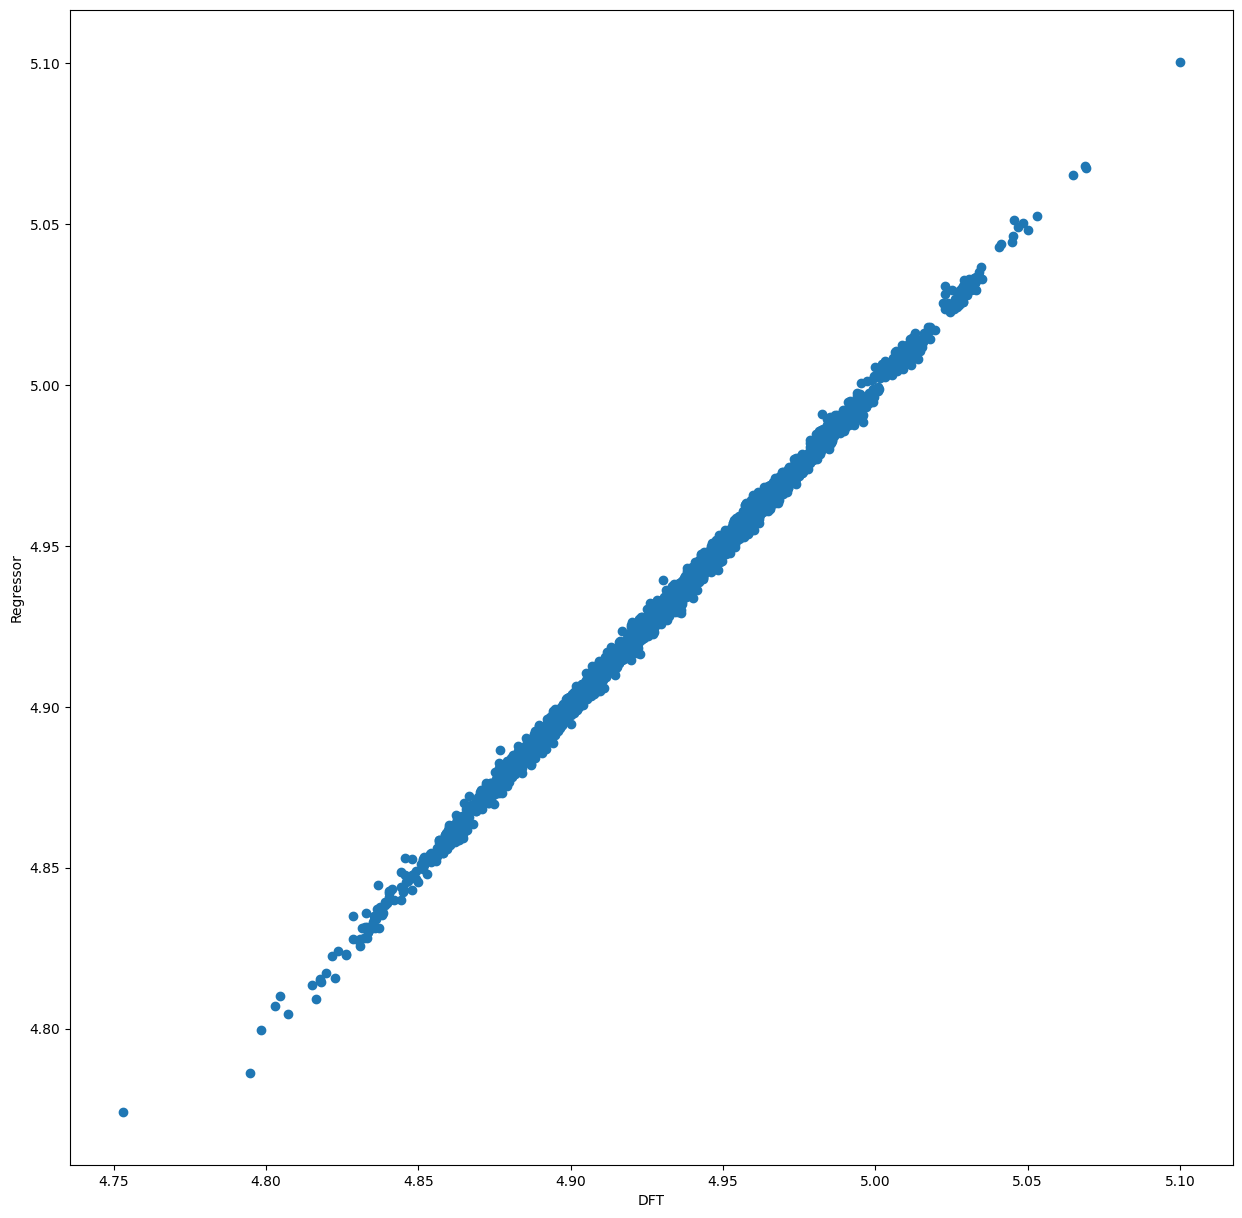

In [124]:
import matplotlib.pyplot as plt
scaler = scaler.fit(X_train)
X_all = scaler.transform(cm_list)
plt.scatter(gap_cell, reg.predict(cm_list))# plot the predicted versus the actual gaps
plt.xlabel('DFT')
plt.ylabel('Regressor')

## MBTR

In [167]:
structure_test = copy.deepcopy(structures[0])
structure_test.remove_species('O')

In [168]:
structure_test

Structure Summary
Lattice
    abc : 10.263312965012288 10.263312965012288 10.263312965012288
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 764.4475956535364
      A : 0.0 7.257258195 7.257258195
      B : 7.257258195 0.0 7.257258195
      C : 7.257258195 7.257258195 0.0
    pbc : True True True
PeriodicSite: Mg (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Mg (2.4191, 2.4191, 0.0000) [0.0000, 0.0000, 0.3333]
PeriodicSite: Mg (-2.4191, -2.4191, -0.0000) [-0.0000, -0.0000, -0.3333]
PeriodicSite: Mg (2.4191, 0.0000, 2.4191) [0.0000, 0.3333, -0.0000]
PeriodicSite: Mg (4.8382, 2.4191, 2.4191) [0.0000, 0.3333, 0.3333]
PeriodicSite: Mg (-0.0000, -2.4191, 2.4191) [-0.0000, 0.3333, -0.3333]
PeriodicSite: Mg (-2.4191, -0.0000, -2.4191) [-0.0000, -0.3333, 0.0000]
PeriodicSite: Mg (0.0000, 2.4191, -2.4191) [0.0000, -0.3333, 0.3333]
PeriodicSite: Mg (-4.8382, -2.4191, -2.4191) [-0.0000, -0.3333, -0.3333]
PeriodicSite: Mg (0.0000, 2.4191, 2.4191) [0.3333

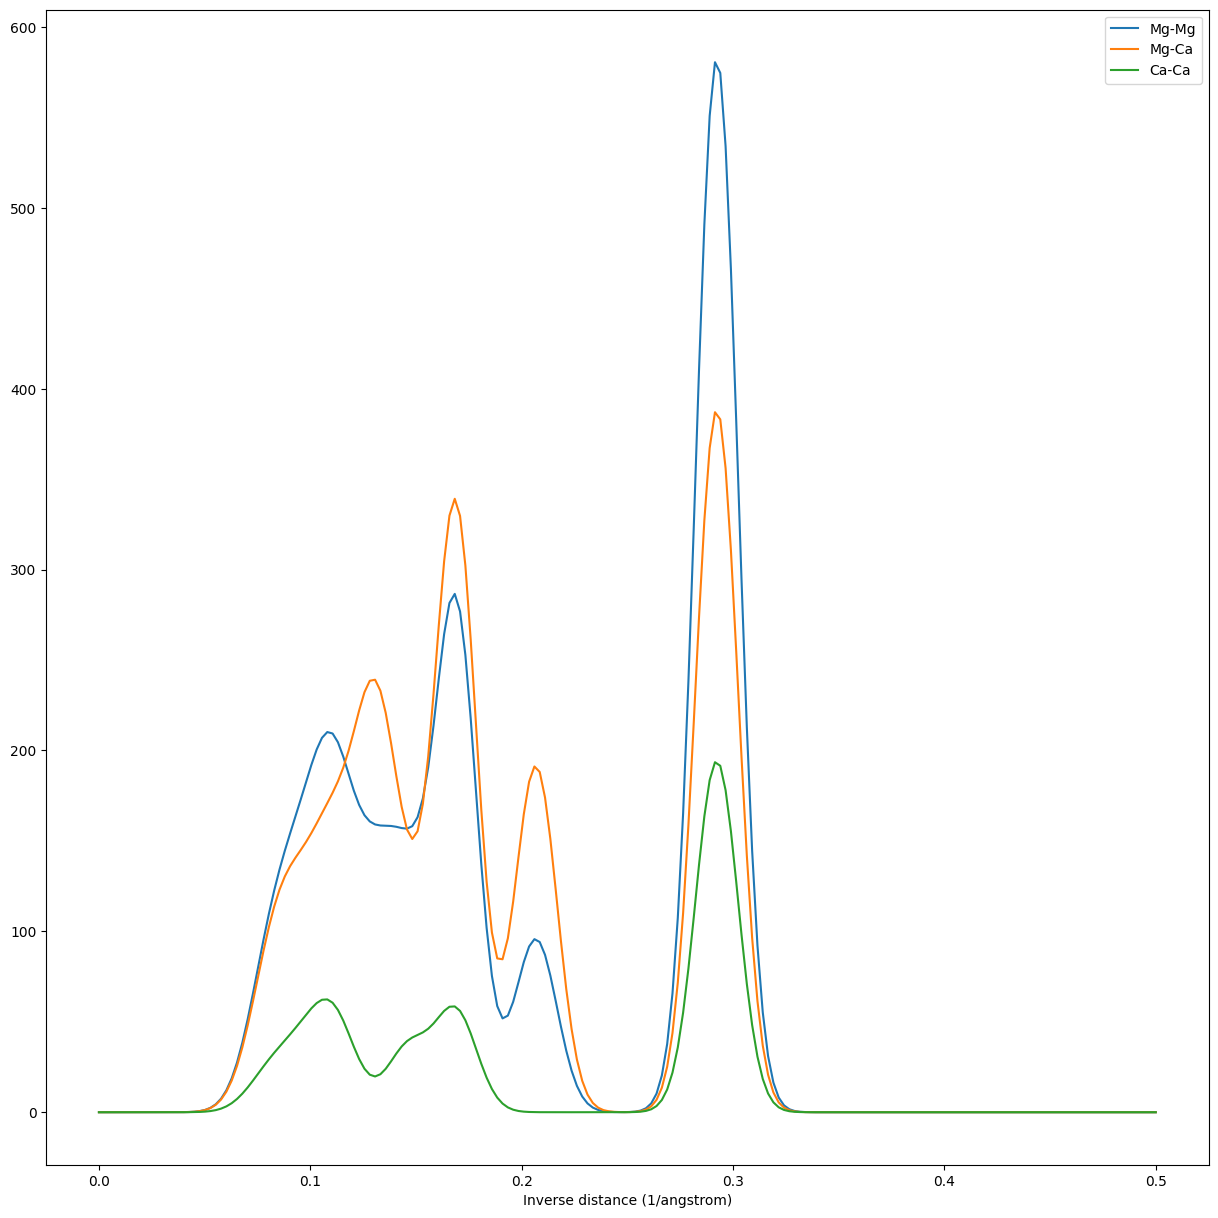

In [169]:
import matplotlib.pyplot as mpl
from dscribe.descriptors import MBTR
import ase


structure = structure_test
decay = 0.5
mbtr = MBTR(
    species=["Ca","Mg"],
    #species=["Ca", "Mg","O"],
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 0.5, "sigma": 0.01, "n": 200},
        "weighting": {"function": "exp", "scale": decay, "threshold": 1e-3},
    },
    periodic=True,
    flatten=False,
    sparse=False
)
structure_ase = AseAtomsAdaptor().get_atoms(structure)
mbtr_output = mbtr.create(structure_ase)

# Create the mapping between an index in the output and the corresponding
# chemical symbol
n_elements = len(mbtr.species)
imap = mbtr.index_to_atomic_number
x = np.linspace(0, 0.5, 200)
smap = {index: ase.data.chemical_symbols[number] for index, number in imap.items()}

# Plot k=2
fig, ax = mpl.subplots()
for i in range(n_elements):
    for j in range(n_elements):
        if j >= i:
            mpl.plot(x, mbtr_output["k2"][i, j, :], label="{}-{}".format(smap[i], smap[j]))
ax.set_xlabel("Inverse distance (1/angstrom)")
ax.legend()


In [155]:
mbtr_output['k2'][0,0,:]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.05170954e-06,
       1.63533714e-05, 5.11116268e-05, 2.12259940e-04, 6.84056897e-04,
       2.17820564e-03, 6.60465518e-03, 1.85640715e-02, 4.96071950e-02,
       1.24764852e-01, 2.96449244e-01, 6.65228248e-01, 1.41113365e+00,
       2.83148360e+00, 5.37809610e+00, 9.67839718e+00, 1.65177441e+01,
       2.67631016e+01, 4.12193947e+01, 6.04338608e+01, 8.44883270e+01,
       1.12860146e+02, 1.44410095e+02, 1.77514923e+02, 2.10346405e+02,
       2.41278625e+02, 2.69155823e+02, 2.93509491e+02, 3.14623962e+02,
       3.33314911e+02, 3.50801788e+02, 3.68133545e+02, 3.85888123e+02,
       4.03793488e+02, 4.20618439e+02, 4.34474915e+02, 4.43474640e+02,
       4.46546478e+02, 4.44055878e+02, 4.37838776e+02, 4.30519531e+02,
       4.24667023e+02, 4.21424652e+02, 4.20486023e+02, 4.20052032e+02,
       4.18005737e+02, 4.12586334e+02, 4.03216949e+02, 3.90528961e+02,
      

## SOAP

In [7]:
from dscribe.descriptors import SOAP

species = [12,20,8]
r_cut = 6.0
n_max = 8
l_max = 6

periodic_soap = SOAP(
    species=species,
    r_cut=r_cut,
    n_max=n_max,
    l_max=n_max,
    periodic=True,
    sparse=False
)

structure_ase = AseAtomsAdaptor().get_atoms(structures[0])
soap = periodic_soap.create(structure_ase)

In [12]:
soap

array([[ 0.00407854,  0.0049643 ,  0.068268  , ...,  0.14486746,
        -0.15714421,  0.17266281],
       [ 0.00407854,  0.0049643 ,  0.068268  , ...,  0.14486746,
        -0.15714421,  0.17266281],
       [ 0.00407854,  0.0049643 ,  0.068268  , ...,  0.14486746,
        -0.15714421,  0.17266281],
       ...,
       [ 0.009342  ,  0.06732734,  0.08015435, ...,  0.07851505,
        -0.07293918,  0.07591345],
       [ 0.009342  ,  0.06732734,  0.08015435, ...,  0.07851505,
        -0.07293918,  0.07591345],
       [ 0.009342  ,  0.06732734,  0.08015435, ...,  0.07851505,
        -0.07293918,  0.07591345]])

# <a id='ml'>Machine Learning</a>

### ML model

In [155]:
x = descriptor_4
y = np.array(energies_sp)

## Data normalisation

#### MinMaxScaler

In [92]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 

X_train, X_test, y_train, y_test = train_test_split(descriptor_4, energies_sp, random_state=1)

scaler = MinMaxScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

#### StandardScaler

In [408]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

## k-Nearest Neighbour clustering 

### Find neighbours

In [401]:
#X = neighbours_spatial_dist_all_sorted_sliced_flat
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(descriptor_4)
distances, indices = nbrs.kneighbors(descriptor_4)
indices[0,:]

array([ 0,  3,  2,  1, 21, 73, 23, 17, 18, 15])

In [399]:
indices[0,:]

array([  0,   3,   2,   1,  21,  23,  73,  18,  17,  24,  15,  70,   7,
        20,  66, 560,  71,   9,  10, 510,  11,  22, 507,  72, 564,  67,
       888, 567, 557,   6, 566,  16,   8, 890, 891,   4,  13,  19, 508,
        69,  65,  12, 556,   5,  68, 563, 893, 503,  14, 887, 884, 498,
       886, 499, 562, 509, 505, 894, 500, 565, 555, 506, 558, 504, 502,
       892, 501, 889,  64, 885, 895, 559, 561,  61, 233,  44, 240,  43,
       134, 236, 227, 239, 144, 156, 115, 225, 155,  42, 150, 153, 157,
       226, 997, 149, 551,  40, 130,  32,  59, 985])

In [403]:
#X = neighbours_spatial_dist_all_sorted_sliced_flat
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(cm_list)
distances, indices_cm = nbrs.kneighbors(cm_list)
indices_cm[0,:]

array([  0,   3,   1,   2, 507,  24, 566, 585,  63, 500])

In [402]:
indices_cm[0,:]

array([   0,    3,    1,    2,  507,   24,  566,  585,   63,  500,  505,
        892,  574,  568,  893,  578,  609,  569,  573,   72,  501,  560,
       1261,   14,  563,    7,  596,  968,  564,   12,  592,  510,  582,
        605,  557,  606,  567,   73,  589,  570,  891,   23,   11,  502,
        556,   67,  584,  888, 3026,  561, 1132,  600,  508,  886,  612,
         19,  209,  554,  634,  558, 1299, 1720,  611,  562,   44,  499,
        895,  591,  503,  884,  583,  889,  601,    9,   13,  580,  572,
         17,  555, 1001,    8,   20, 1164,  538,  923,  576,  698,  969,
        628, 1143, 1128,  740,  942, 1733,   68,   66, 1176, 1107, 1871,
        607])

### k-means

In [47]:
kmeans = KMeans(n_clusters=500, random_state=0).fit(neighbours_spatial_dist_all_sorted_sliced_reduced)
sort = np.argsort(kmeans.labels_)

In [27]:
kmeans.labels_[0:100]

array([49, 49, 49, 49, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 41, 41, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 43, 41, 41,  2, 41, 41, 41, 41,  8, 46, 18, 18, 18, 18, 46,
       18, 18, 46, 46, 36, 36, 34, 18, 18, 36, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 46, 18, 18, 36, 18, 18, 36, 18, 18, 18, 18,
       18, 18, 18, 18, 22, 18, 18, 36, 18, 18, 36, 18, 36, 18, 18],
      dtype=int32)

In [28]:
kmeans.cluster_centers_

array([[12.        , 12.        , 12.        , ..., 12.76190476,
        13.65079365, 14.92063492],
       [12.        , 12.        , 12.        , ..., 13.07865169,
        16.85393258, 13.34831461],
       [12.        , 12.        , 12.        , ..., 13.42857143,
        13.85714286, 14.85714286],
       ...,
       [12.        , 12.        , 12.        , ..., 14.7012987 ,
        15.01298701, 15.84415584],
       [12.        , 12.        , 12.        , ..., 15.57723577,
        14.60162602, 16.03252033],
       [12.        , 12.        , 12.        , ..., 12.19047619,
        12.38095238, 14.0952381 ]])

### Distance from cluster center

In [48]:
cluster_center_distance = []
for i in range(len(structures)):
    cluster = kmeans.labels_[i]
    #dist = np.linalg.norm(neighbours_spatial_dist_all_sorted_sliced_flat[i]- kmeans.cluster_centers_[cluster])
    dist = np.linalg.norm(neighbours_spatial_dist_all_sorted_sliced_reduced[i]- kmeans.cluster_centers_[cluster])
    
    cluster_center_distance.append(dist)
cluster_center_distance = np.array(cluster_center_distance)

### Central structure

In [49]:
cluster_central_strucure = []
for i in range(kmeans.n_clusters):
    cluster_items = np.where(kmeans.labels_ == i)[0]
    central_structure = np.where(cluster_center_distance == np.min(cluster_center_distance[cluster_items]))[0][0]
    cluster_central_strucure.append(central_structure)

### Central structure + n_irreducible_atoms

In [37]:
n_irr_atoms = np.array(n_irr_atoms)
top = 0.1
for i in range(kmeans.n_clusters):
    cluster_items = np.where(kmeans.labels_ == i)[0]
    #print(cluster_items)
    cluster_sort = np.argsort(cluster_center_distance[cluster_items])
    #print( cluster_sort )
    n_structures = round(len(cluster_items)*top)
    top_structures = cluster_items[cluster_sort][0:n_structures]
    #print(top_structures)
    structure_min_atoms_top_index = np.argmin(n_irr_atoms[top_structures])
    #print( structure_min_atoms_top_index,np.min(n_irr_atoms[top_structures]) )
    structure_min_atoms = top_structures[structure_min_atoms_top_index]
    print(structure_min_atoms,n_irr_atoms[structure_min_atoms])

NameError: name 'n_irr_atoms' is not defined

### KNeighborsRegressor

In [216]:
X_train.shape

(3218, 1728)

In [379]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(descriptor_4_bin_norm, energies_sp,test_size=0.2)

'''#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) '''

for i in range(2,10):    
    print()
    print(i)
        
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train,y_train)
    
    predictions_train_LR = model.predict(X_train)
    
    train_error_LR= np.sqrt(mean_squared_error(y_train, predictions_train_LR))
    print('Train Error:',train_error_LR)
    #Test Error
    predictions_test_LR = model.predict(X_test)
    test_error_LR= np.sqrt(mean_squared_error(y_test, predictions_test_LR))
    print('Test Error:', test_error_LR)
    #evaluate the R^2
    score_LR=model.score(X_train, y_train) #returns the R^2 score
    print('R^2 returned by the KNeighborsRegressor:',score_LR)
    
    
    


2
Train Error: 0.01524238218650494
Test Error: 0.026333720726704476
R^2 returned by the KNeighborsRegressor: 0.9170716927213769

3
Train Error: 0.01686489479179757
Test Error: 0.02434673155548099
R^2 returned by the KNeighborsRegressor: 0.8984770147718723

4
Train Error: 0.017758601049860382
Test Error: 0.023523335414078597
R^2 returned by the KNeighborsRegressor: 0.8874320884979279

5
Train Error: 0.01820568691560509
Test Error: 0.023255486711864583
R^2 returned by the KNeighborsRegressor: 0.881692780739221

6
Train Error: 0.018714099218491275
Test Error: 0.02304510358604965
R^2 returned by the KNeighborsRegressor: 0.8749928188110446

7
Train Error: 0.018990459704952303
Test Error: 0.022613062079071513
R^2 returned by the KNeighborsRegressor: 0.8712734699106337

8
Train Error: 0.01938911958854459
Test Error: 0.022678733163741655
R^2 returned by the KNeighborsRegressor: 0.8658121218925339

9
Train Error: 0.01970239707846712
Test Error: 0.02264815841947709
R^2 returned by the KNeighbor

## Neural networks

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.5)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

#pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000))

#pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)

regr = MLPRegressor(hidden_layer_sizes=(300,),random_state=1, max_iter=500,solver='lbfgs').fit(X_train, y_train)

In [20]:
from sklearn.metrics import mean_squared_error as mse
#Training Error
predictions_train_LR = regr.predict(X_train)
train_error_LR= mse(y_train, predictions_train_LR)
print('Training Error:',train_error_LR)
#Test Error
predictions_test_LR = regr.predict(X_test)
test_error_LR= mse(y_test, predictions_test_LR)
print('Test Error:', test_error_LR)
#evaluate the R^2
score_LR=regr.score(X_train, y_train) #returns the R^2 score
print('R^2 returned by the linear regression:',score_LR)

Training Error: 2.1365553156970135e-08
Test Error: 1122019562704.3523
R^2 returned by the linear regression: 0.9999923963729976


## Linear regression

In [160]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42,test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.50)

#create the object
scaler=StandardScaler()
scaler=MinMaxScaler()
#fit mu and sigma and apply to X_train
X_train=scaler.fit_transform(X_train)
#apply the same transformation to the test set
X_test=scaler.transform(X_test)

reg = LinearRegression() #create the object
reg.fit(X_train, y_train)

LinearRegression()

In [161]:
from sklearn.metrics import mean_squared_error as mse
#Training Error
predictions_train_LR = reg.predict(X_train)
train_error_LR= mse(y_train, predictions_train_LR)
print('Training Error:',train_error_LR)
#Test Error
predictions_test_LR = reg.predict(X_test)
test_error_LR= mse(y_test, predictions_test_LR)
print('Test Error:', test_error_LR)
#evaluate the R^2
score_LR=reg.score(X_train, y_train) #returns the R^2 score
print('R^2 returned by the linear regression:',score_LR)

Training Error: 3.184589852360904e-07
Test Error: 6.396711137886732e+16
R^2 returned by the linear regression: 0.9998848896068365


In [216]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

#pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000))

#pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


regr = MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000).fit(X_train, y_train)

### Cosine similarity one by one

In [242]:
vector_descriptor = neighbours_spatial_dist_all_sorted_sliced_flat
a = vector_descriptor[0]
for i in range(len(neighbours_spatial_dist_all_sorted_sliced_flat)):   
    b = vector_descriptor[i]
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    print(cos_sim)

1.0000000000000002
0.9761646803900327
0.9737570723486219
0.9764054411941738
0.9679788130492358
0.9689418562658001
0.9699048994823645
0.9679788130492358
0.968460334657518
0.9706271818947877
0.9708679426989288
0.9682195738533769
0.9696641386782234
0.9682195738533769
0.9687010954616591
0.9689418562658001
0.9677380522450947
0.971349464307211
0.9701456602865056
0.968460334657518
0.9687010954616591
0.9677380522450947
0.9696641386782234
0.9677380522450947
0.9696641386782234
0.9694233778740823
0.9703864210906467
0.9679788130492358
0.968460334657518
0.9699048994823645
0.9701456602865056
0.9687010954616591
0.9689418562658001
0.9691826170699412
0.9689418562658001
0.9677380522450947
0.9701456602865056
0.9691826170699412
0.9689418562658001
0.9708679426989288
0.9696641386782234
0.9665342482243893
0.9703864210906467
0.9694233778740823
0.9665342482243893
0.9689418562658001
0.9718309859154932
0.9674972914409536
0.968460334657518
0.9703864210906467
0.9689418562658001
0.9703864210906467
0.966775009028530

0.9631635969664141
0.9638858793788373
0.9660527266161071
0.9634043577705552
0.9648489225954017
0.9646081617912606
0.962922836162273
0.9636451185746963
0.9674972914409536
0.9648489225954017
0.9655712050078249
0.9667750090285304
0.9665342482243893
0.9665342482243893
0.9626820753581319
0.9653304442036839
0.9660527266161071
0.9665342482243893
0.965811965811966
0.9667750090285304
0.9665342482243893
0.9660527266161071
0.9667750090285304
0.9662934874202482
0.9650896833995428
0.965811965811966
0.9655712050078249
0.9682195738533769
0.965811965811966
0.9665342482243893
0.9631635969664141
0.9662934874202482
0.9665342482243893
0.9636451185746963
0.9655712050078249
0.962922836162273
0.9665342482243893
0.9653304442036839
0.9667750090285304
0.9674972914409536
0.9670157698326715
0.9670157698326715
0.9631635969664141
0.9665342482243893
0.9662934874202482
0.965811965811966
0.9677380522450947
0.9662934874202482
0.9634043577705552
0.9626820753581319
0.9660527266161071
0.965811965811966
0.9641266401829784


### Cosine similarity matrix

In [110]:
vector_descriptor = np.array(neighbours_spatial_dist_all_sorted_sliced_flat)[sort]
cos_sim_2d = []
n_elements = len(neighbours_spatial_dist_all_sorted_sliced_flat)


for i in range(n_elements):
    cos_sim_line = []
    a = vector_descriptor[i]
    for j in range(n_elements):
        b = vector_descriptor[j]
        cos_sim_line.append(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    cos_sim_2d.append(cos_sim_line)

In [111]:
np.array(cos_sim_2d)

array([[1.        , 0.97818297, 0.97932456, ..., 0.97513873, 0.97970509,
        0.97666085],
       [0.97818297, 1.        , 0.98046615, ..., 0.97628032, 0.98084668,
        0.97792928],
       [0.97932456, 0.98046615, 1.        , ..., 0.97501189, 0.98059299,
        0.98160774],
       ...,
       [0.97513873, 0.97628032, 0.97501189, ..., 1.        , 0.97513873,
        0.97551926],
       [0.97970509, 0.98084668, 0.98059299, ..., 0.97513873, 1.        ,
        0.97754876],
       [0.97666085, 0.97792928, 0.98160774, ..., 0.97551926, 0.97754876,
        1.        ]])

In [112]:
tst = []
for i in dist_std_first:
    tst.append(sort.tolist().index(i))

NameError: name 'dist_std_first' is not defined

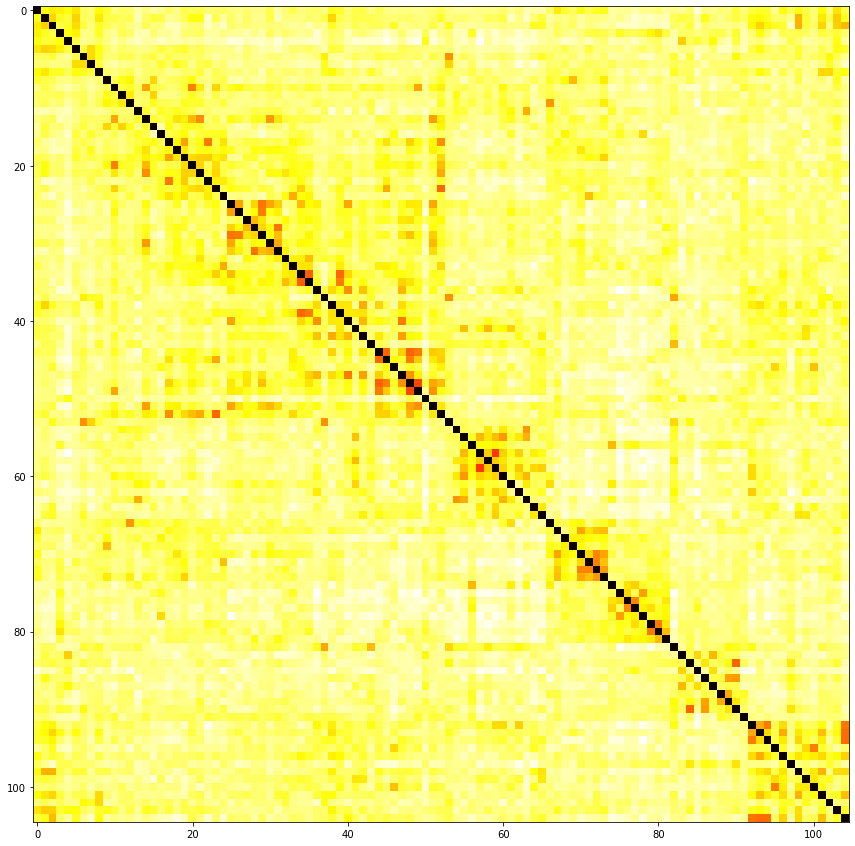

In [113]:
a = 1-np.array(cos_sim_2d)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.scatter(tst,tst)
plt.show()

# <a id='crystal'>CRYSTAL CaMgO</a>

## Write all the structures

In [63]:
#SP
crystal_input = Crystal_input().from_file('./data/crystal/high_tol/cao_bulk_sp.d12')

n_subs = 9

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
mg_atoms = np.array(ca_atoms)+1

data = copy.deepcopy(data_slurm)
for i,config in enumerate(mg_atoms):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    crystal_input_tmp.geom_block.insert(11,'ATOMSUBS\n')
    crystal_input_tmp.geom_block.insert(12,'%s\n'%(str(n_subs)))
    for j in range(n_subs):
        crystal_input_tmp.geom_block.insert(13+j,'%s 12\n'%(str(mg_atoms[i][j])))
    with open('./data/crystal/high_tol/sp/CaMgO_sp_%s.d12'%(i), 'w') as file:
        
            cry_input = list(itertools.chain('Single Point\n',crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_sp_%s &\n'%(i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/high_tol/sp/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch %s_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/high_tol/sp/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)


In [365]:
#OPT CELL
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_cell.d12')

n_subs = len(atom_type_1[0])

slurm_file = './data/slurm_file.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(atom_type_2):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/cell/CaMgO_cell_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm CaMgO_cell_%s CaMgO_cell_%s\n'%(i,i))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys CaMgO_cell_%s\n'%(i))
    data.append('\n\n')

    if i%100 == 0:
    
        with open('./data/crystal/cell/CaMgO_crystal_%s.slurm'%(str(int(i/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/cell/CaMgO_crystal_%s.slurm'%(str(int((i+100)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
print('sbatch CaMgO_crystal_%s.slurm'%(str(int((i+100)/100))))

sbatch CaMgO_crystal_0.slurm
sbatch CaMgO_crystal_1.slurm
sbatch CaMgO_crystal_2.slurm
sbatch CaMgO_crystal_3.slurm
sbatch CaMgO_crystal_4.slurm
sbatch CaMgO_crystal_5.slurm
sbatch CaMgO_crystal_6.slurm
sbatch CaMgO_crystal_7.slurm
sbatch CaMgO_crystal_8.slurm
sbatch CaMgO_crystal_9.slurm
sbatch CaMgO_crystal_10.slurm
sbatch CaMgO_crystal_11.slurm
sbatch CaMgO_crystal_12.slurm
sbatch CaMgO_crystal_13.slurm
sbatch CaMgO_crystal_14.slurm
sbatch CaMgO_crystal_15.slurm
sbatch CaMgO_crystal_16.slurm
sbatch CaMgO_crystal_17.slurm
sbatch CaMgO_crystal_18.slurm
sbatch CaMgO_crystal_19.slurm
sbatch CaMgO_crystal_20.slurm
sbatch CaMgO_crystal_21.slurm
sbatch CaMgO_crystal_22.slurm
sbatch CaMgO_crystal_23.slurm
sbatch CaMgO_crystal_24.slurm
sbatch CaMgO_crystal_25.slurm
sbatch CaMgO_crystal_26.slurm
sbatch CaMgO_crystal_27.slurm
sbatch CaMgO_crystal_28.slurm
sbatch CaMgO_crystal_29.slurm
sbatch CaMgO_crystal_30.slurm
sbatch CaMgO_crystal_31.slurm
sbatch CaMgO_crystal_32.slurm
sbatch CaMgO_crystal

## Read output

In [36]:
#for i in range(len(structures)):
to_do = np.arange(len(structures)).tolist()
file_exist = []
for i in range(len(structures)):
    outut_name = './data/crystal/full/CaMgO_full_tmp_%s.out'%str(i)
    if os.path.isfile(outut_name) == True:
        crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break


In [111]:
for i in range(len(structures)):
    #if i in to_do:
    print('cp CaMgO_full_tmp_%s.optstory/optc10 CaMgO_full_%s.gui'%(str(i),str(i)))
    #print('cp cell/CaMgO_cell_%s.gui full_opt/CaMgO_full_tmp_%s.gui'%(str(i),str(i)))

cp CaMgO_full_tmp_0.optstory/optc10 CaMgO_full_0.gui
cp CaMgO_full_tmp_1.optstory/optc10 CaMgO_full_1.gui
cp CaMgO_full_tmp_2.optstory/optc10 CaMgO_full_2.gui
cp CaMgO_full_tmp_3.optstory/optc10 CaMgO_full_3.gui
cp CaMgO_full_tmp_4.optstory/optc10 CaMgO_full_4.gui
cp CaMgO_full_tmp_5.optstory/optc10 CaMgO_full_5.gui
cp CaMgO_full_tmp_6.optstory/optc10 CaMgO_full_6.gui
cp CaMgO_full_tmp_7.optstory/optc10 CaMgO_full_7.gui
cp CaMgO_full_tmp_8.optstory/optc10 CaMgO_full_8.gui
cp CaMgO_full_tmp_9.optstory/optc10 CaMgO_full_9.gui
cp CaMgO_full_tmp_10.optstory/optc10 CaMgO_full_10.gui
cp CaMgO_full_tmp_11.optstory/optc10 CaMgO_full_11.gui
cp CaMgO_full_tmp_12.optstory/optc10 CaMgO_full_12.gui
cp CaMgO_full_tmp_13.optstory/optc10 CaMgO_full_13.gui
cp CaMgO_full_tmp_14.optstory/optc10 CaMgO_full_14.gui
cp CaMgO_full_tmp_15.optstory/optc10 CaMgO_full_15.gui
cp CaMgO_full_tmp_16.optstory/optc10 CaMgO_full_16.gui
cp CaMgO_full_tmp_17.optstory/optc10 CaMgO_full_17.gui
cp CaMgO_full_tmp_18.optstory/

In [42]:
for i in range(len(structures)):
    if i in to_do:
        print('cp cell/CaMgO_cell_%s.f9 full_opt/CaMgO_full_tmp_%s.f9'%(str(i),str(i)))

cp cell/CaMgO_cell_3987.f9 full_opt/CaMgO_full_tmp_3987.f9
cp cell/CaMgO_cell_3988.f9 full_opt/CaMgO_full_tmp_3988.f9
cp cell/CaMgO_cell_3990.f9 full_opt/CaMgO_full_tmp_3990.f9
cp cell/CaMgO_cell_3991.f9 full_opt/CaMgO_full_tmp_3991.f9
cp cell/CaMgO_cell_3992.f9 full_opt/CaMgO_full_tmp_3992.f9
cp cell/CaMgO_cell_3993.f9 full_opt/CaMgO_full_tmp_3993.f9
cp cell/CaMgO_cell_3994.f9 full_opt/CaMgO_full_tmp_3994.f9
cp cell/CaMgO_cell_3995.f9 full_opt/CaMgO_full_tmp_3995.f9
cp cell/CaMgO_cell_3996.f9 full_opt/CaMgO_full_tmp_3996.f9
cp cell/CaMgO_cell_3997.f9 full_opt/CaMgO_full_tmp_3997.f9
cp cell/CaMgO_cell_3998.f9 full_opt/CaMgO_full_tmp_3998.f9
cp cell/CaMgO_cell_3999.f9 full_opt/CaMgO_full_tmp_3999.f9
cp cell/CaMgO_cell_4000.f9 full_opt/CaMgO_full_tmp_4000.f9
cp cell/CaMgO_cell_4001.f9 full_opt/CaMgO_full_tmp_4001.f9
cp cell/CaMgO_cell_4002.f9 full_opt/CaMgO_full_tmp_4002.f9
cp cell/CaMgO_cell_4003.f9 full_opt/CaMgO_full_tmp_4003.f9
cp cell/CaMgO_cell_4004.f9 full_opt/CaMgO_full_tmp_4004.

In [110]:
#FULLOPT 1 
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full_tmp.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

files = []

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_tmp_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_tmp_%s CaMgO_full_tmp_%s &\n'%(i,i))
    data.append('\n')
    files.append(i)

    if (i+1)%100 == 0:
        data.append('wait\n')
        for j in files:
            data.append('mv CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
            data.append('mv CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
        with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        files = []
        print('sbatch %s_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)
        

sbatch 1_CaMgO_crystal.slurm
sbatch 2_CaMgO_crystal.slurm
sbatch 3_CaMgO_crystal.slurm
sbatch 4_CaMgO_crystal.slurm
sbatch 5_CaMgO_crystal.slurm
sbatch 6_CaMgO_crystal.slurm
sbatch 7_CaMgO_crystal.slurm
sbatch 8_CaMgO_crystal.slurm
sbatch 9_CaMgO_crystal.slurm
sbatch 10_CaMgO_crystal.slurm
sbatch 11_CaMgO_crystal.slurm
sbatch 12_CaMgO_crystal.slurm
sbatch 13_CaMgO_crystal.slurm
sbatch 14_CaMgO_crystal.slurm
sbatch 15_CaMgO_crystal.slurm
sbatch 16_CaMgO_crystal.slurm
sbatch 17_CaMgO_crystal.slurm
sbatch 18_CaMgO_crystal.slurm
sbatch 19_CaMgO_crystal.slurm
sbatch 20_CaMgO_crystal.slurm
sbatch 21_CaMgO_crystal.slurm
sbatch 22_CaMgO_crystal.slurm
sbatch 23_CaMgO_crystal.slurm
sbatch 24_CaMgO_crystal.slurm
sbatch 25_CaMgO_crystal.slurm
sbatch 26_CaMgO_crystal.slurm
sbatch 27_CaMgO_crystal.slurm
sbatch 28_CaMgO_crystal.slurm
sbatch 29_CaMgO_crystal.slurm
sbatch 30_CaMgO_crystal.slurm
sbatch 31_CaMgO_crystal.slurm
sbatch 32_CaMgO_crystal.slurm
sbatch 33_CaMgO_crystal.slurm
sbatch 34_CaMgO_cry

## Read output and optstory

In [138]:
#for i in range(len(structures)):
gui_to_do = np.arange(len(structures)).tolist()
out_to_do = np.arange(len(structures)).tolist()
out_file_exist = []
optc10 = []
optc09 = []
optc08 = []
for i in range(len(structures)):
    gui_name_10 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc10'%str(i)
    gui_name_9 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc09'%str(i)
    gui_name_8 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc09'%str(i)
    out_name = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.out'%str(i)
    if os.path.isfile(gui_name_10) == True:
        gui_to_do.remove(i)
        optc10.append(i)
        sh.copy(gui_name_10,'./data/crystal/full_inp/CaMgO_full_%s.gui'%str(i))
    elif os.path.isfile(gui_name_9) == True:
        gui_to_do.remove(i)
        sh.copy(gui_name_9,'./data/crystal/full_inp/CaMgO_full_%s.gui'%str(i))
    '''elif os.path.isfile(gui_name_8) == True:
        gui_to_do.remove(i)
        optc08.append(i)'''
    if os.path.isfile(out_name) == True:
        out_file_exist.append(i)
        crystal_output = Crystal_output().read_cry_output(out_name)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                out_to_do.remove(i)
                break
        
        '''crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break'''


In [105]:
#FULLOPT 1 
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full_tmp.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

files = []

data = copy.deepcopy(data_slurm)
for i,k in enumerate(to_do):
    
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_tmp_%s.d12'%(k), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_tmp_%s CaMgO_full_tmp_%s &\n'%(k,k))
    data.append('\n')
    files.append(k)

    if (i+1)%100 == 0:
        data.append('wait\n')
        for j in files:
            data.append('cp CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
            data.append('cp CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
        with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        files = []
        print('sbatch %s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for j in files:
        data.append('cp CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
        data.append('cp CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
    for line in data:
        file.writelines(line)
        

# <a id='crystal_lts'>CRYSTAL LTS</a>

In [60]:
n_symmops = []
for i,config in enumerate(structures):
    #crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/cell/CaMgO_cell_%s.gui'%str(i))
    crystal_gui = cry_pmg2gui(config)
    #print(crystal_gui.n_symmops)
    #crystal_gui.write_crystal_gui('./data/crystal/lts/symmetry_analysis/lts_%s.gui'%i)
    n_symmops.append(crystal_gui.n_symmops)
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.sort(n_symmops)[::-1]
n_symmops_sorted_structures = np.argsort(n_symmops)[::-1]

unique_symmops = np.unique(np.sort(n_symmops))[::-1]
first_structure_sp = np.unique(np.sort(n_symmops)[::-1],return_index=True)[1][::-1]
num_structure_sp = np.unique(np.sort(n_symmops)[::-1],return_counts=True)[1][::-1]

In [117]:
#SP 
crystal_input = Crystal_input().from_file('./data/crystal/lts/lts_sp_input.d12')

n_subs = 18

first_structure_sp = np.append(first_structure_sp,(len(structures)+1))

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
#Only use this once
#li_atoms = np.array(li_atoms)+1

data = copy.deepcopy(data_slurm)

#first_structure_sp = np.append(first_structure_sp,(len(structures)+1))

for k in range(6):
    path = './data/crystal/lts/sp/%s'%unique_symmops[k]
    if os.path.exists(path) == False:
        os.makedirs(path)
    
    data = copy.deepcopy(data_slurm)
    index = 0
    index_2 = 0
    
    print(unique_symmops[k])
    structures_sp = n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]
    print(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]],len(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]))
    
        
    for i in structures_sp:
        index += 1
        
        sh.copy('./data/crystal/lts/lts_sp_input.d12',path+'/lts_sp_%s.d12'%(i))
        
        crystal_gui = cry_pmg2gui(structures[i])
        crystal_gui.write_crystal_gui(path+'/lts_sp_%s.gui'%(i))
        crystal_input_tmp = copy.deepcopy(crystal_input)
        #crystal_input_tmp.geom_block.insert(-1,'ATOMSUBS\n')
        #crystal_input_tmp.geom_block.insert(-1,'%s\n'%(str(n_subs)))

        #for j in range(n_subs):
            #crystal_input_tmp.geom_block.insert(-1,'%s 3\n'%(str(li_atoms[i][j])))
        #with open(path+'/lts_sp_%s.d12'%(i), 'w') as file:

                #cry_input = list(itertools.chain('Single Point\n',crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                                #crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
                #for line in cry_input:
                    #file.writelines(line)
        #### prepare slurm NEW! !
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi lts_sp_%s &\n\n'%(i))
        
        if index == 50:
            data[4] = '#SBATCH --nodes=50\n'
            data.append('wait\n')
            with open(path+'/%s_%s_lts_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
                for line in data:
                    file.writelines(line)
            data = copy.deepcopy(data_slurm)
            index_2 += 1
            index = 0
            
    data.append('wait\n')
    data[4] = '#SBATCH --nodes=%s\n'%index
    with open(path+'/%s_%s_lts_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
        for line in data:
            file.writelines(line)

8
[4008 2009 3962 1817 4007] 5
6
[ 0 64 46 63] 4
4
[  25 4003  642  836 3989  511 1843 1445  159 3290 3289] 11
3
[3291] 1
2
[2278 2059 2088 2082 2072 2063 2053 2094 2043 2286 2041 2039 2037 2016
 2091 2099 2257 2104 2269 2108 2272 2119 2128 2281 2013 2130 2245 2273
 2266 2250 2252 2015 1960 4021 1877 1871 1869 1864 1846 1842 1840 1837
 1835 1831 1824 1822 1820 1816 1770 1739 1875 1881 2010 1883 1988 1986
 1976 1969 1962 2301 1958 1956 1952 1947 1945 1926 1925 1886 1885 2289
 2343 2302 3129 3063 3033 3029 3026 3025 3015 3013 3010 3009 3008 3006
 3005 3003 3001 3000 3115 3185 2995 3186 3605 3603 3591 3565 3561 3537
 3521 3287 3286 3274 3263 3248 3241 3219 3207 2997 2994 2312 2535 2511
 2501 2433 2431 2424 2423 2401 2399 2398 2395 1737 2339 2331 2326 2314
 2522 2537 2991 2544 2990 2988 2986 2985 2984 2982 2980 2979 2917 2789
 2785 2783 2564 2547 2546 1738 1630 1733  292  403  315  314  313  310
  308  293  278 1731  275  273  271  265  253  251  250  404  466  477
  478  567  565  563  55

In [586]:
i = 3
for i in n_symmops_sorted_structures[first_structure_sp[i]:first_structure_sp[i+1]]:
    print('cp lts_optgeom_cell_%s.f9 lts_optgeom_full_%s.f9'%(i,i))

cp lts_optgeom_cell_3291.f9 lts_optgeom_full_3291.f9


In [471]:
#CELL
crystal_input = Crystal_input().from_file('./data/crystal/lts/lts_optgeom_cell_input.d12')

n_subs = 18

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
#Only use this once
#li_atoms = np.array(li_atoms)+1

data = copy.deepcopy(data_slurm)

#first_structure_sp = np.append(first_structure_sp,(len(structures)+1))

for k in range(5):
    path = './data/crystal/lts/sp/%s'%unique_symmops[k]
    if os.path.exists(path) == False:
        os.makedirs(path)
    
    data = copy.deepcopy(data_slurm)
    index = 0
    index_2 = 0
    
    print(unique_symmops[k])
    structures_sp = n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]
    print(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]],
         len(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]))
    
        
    for i in structures_sp:
        index += 1
        
        sh.copy('./data/crystal/lts/lts_optgeom_input.d12',path+'/lts_optgeom_cell_%s.d12'%(i))
        
        crystal_gui = cry_pmg2gui(structures[i])
        crystal_gui.write_crystal_gui(path+'/lts_optgeom_cell_%s.gui'%(i))
        crystal_input_tmp = copy.deepcopy(crystal_input)
        #crystal_input_tmp.geom_block.insert(-1,'ATOMSUBS\n')
        #crystal_input_tmp.geom_block.insert(-1,'%s\n'%(str(n_subs)))

        #for j in range(n_subs):
            #crystal_input_tmp.geom_block.insert(-1,'%s 3\n'%(str(li_atoms[i][j])))
        #with open(path+'/lts_sp_%s.d12'%(i), 'w') as file:

                #cry_input = list(itertools.chain('Single Point\n',crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                                #crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
                #for line in cry_input:
                    #file.writelines(line)
        #### prepare slurm NEW! !
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi lts_optgeom_cell_%s lts_sp_%s &\n\n'%(i,i))
        
        if index == 50:
            data[4] = '#SBATCH --nodes=50\n'
            data.append('wait\n')
            with open(path+'/%s_%s_lts_cell_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
                for line in data:
                    file.writelines(line)
            data = copy.deepcopy(data_slurm)
            index_2 += 1
            index = 0
            
    data.append('wait\n')
    data[4] = '#SBATCH --nodes=%s\n'%index
    with open(path+'/%s_%s_lts_cell_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
        for line in data:
            file.writelines(line)

8
[4008 2009 3962 1817 4007] 5
6
[ 0 64 46 63] 4
4
[  25 4003  642  836 3989  511 1843 1445  159 3290 3289] 11
3
[3291] 1
2
[2278 2059 2088 2082 2072 2063 2053 2094 2043 2286 2041 2039 2037 2016
 2091 2099 2257 2104 2269 2108 2272 2119 2128 2281 2013 2130 2245 2273
 2266 2250 2252 2015 1960 4021 1877 1871 1869 1864 1846 1842 1840 1837
 1835 1831 1824 1822 1820 1816 1770 1739 1875 1881 2010 1883 1988 1986
 1976 1969 1962 2301 1958 1956 1952 1947 1945 1926 1925 1886 1885 2289
 2343 2302 3129 3063 3033 3029 3026 3025 3015 3013 3010 3009 3008 3006
 3005 3003 3001 3000 3115 3185 2995 3186 3605 3603 3591 3565 3561 3537
 3521 3287 3286 3274 3263 3248 3241 3219 3207 2997 2994 2312 2535 2511
 2501 2433 2431 2424 2423 2401 2399 2398 2395 1737 2339 2331 2326 2314
 2522 2537 2991 2544 2990 2988 2986 2985 2984 2982 2980 2979 2917 2789
 2785 2783 2564 2547 2546 1738 1630 1733  292  403  315  314  313  310
  308  293  278 1731  275  273  271  265  253  251  250  404  466  477
  478  567  565  563  55

In [763]:
#FULLOPT
crystal_input = Crystal_input().from_file('./data/crystal/lts/lts_optgeom_full_input.d12')

n_subs = 18

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
#Only use this once
#li_atoms = np.array(li_atoms)+1

data = copy.deepcopy(data_slurm)

#first_structure_sp = np.append(first_structure_sp,(len(structures)+1))

for k in range(4):
    path = './data/crystal/lts/sp/%s'%unique_symmops[k]
    if os.path.exists(path) == False:
        os.makedirs(path)
    
    data = copy.deepcopy(data_slurm)
    index = 0
    index_2 = 0
    
    print(unique_symmops[k])
    structures_sp = n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]
    print(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]],
         len(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]))
    
        
    for i in structures_sp:
        index += 1
        
        sh.copy('./data/crystal/lts/lts_optgeom_full_input.d12',path+'/lts_optgeom_full_%s.d12'%(i))
        
        crystal_gui = cry_pmg2gui(structures[i])
        crystal_gui.write_crystal_gui(path+'/lts_optgeom_full_%s.gui'%(i))
        crystal_input_tmp = copy.deepcopy(crystal_input)
        #crystal_input_tmp.geom_block.insert(-1,'ATOMSUBS\n')
        #crystal_input_tmp.geom_block.insert(-1,'%s\n'%(str(n_subs)))

        #for j in range(n_subs):
            #crystal_input_tmp.geom_block.insert(-1,'%s 3\n'%(str(li_atoms[i][j])))
        #with open(path+'/lts_sp_%s.d12'%(i), 'w') as file:

                #cry_input = list(itertools.chain('Single Point\n',crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                                #crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
                #for line in cry_input:
                    #file.writelines(line)
        #### prepare slurm NEW! !
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi lts_optgeom_full_%s lts_optgeom_full_%s &\n\n'%(i,i))
        
        if index == 50:
            data[4] = '#SBATCH --nodes=50\n'
            data.append('wait\n')
            with open(path+'/%s_%s_lts_full_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
                for line in data:
                    file.writelines(line)
                for steps in range(4):
                    for line in data[22:]:
                        file.writelines(line)
            data = copy.deepcopy(data_slurm)
            index_2 += 1
            index = 0
            
    data.append('wait\n\n')
    data[4] = '#SBATCH --nodes=%s\n'%index
    with open(path+'/%s_%s_lts_full_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
        for line in data:
            file.writelines(line)
        for steps in range(4):
            for line in data[22:]:
                file.writelines(line)

8
[4008 2009 3962 1817 4007] 5
6
[ 0 64 46 63] 4
4
[  25 4003  642  836 3989  511 1843 1445  159 3290 3289] 11
3
[3291] 1


In [7]:
import re
#READ OUTPUT
crystal_output_folder = './data/crystal/lts/sp/output/'

n_subs = 18

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
#Only use this once
#li_atoms = np.array(li_atoms)+1

data = copy.deepcopy(data_slurm)

#first_structure_sp = np.append(first_structure_sp,(len(structures)+1))

for k in range(4):
    path = './data/crystal/lts/sp/%s'%unique_symmops[k]
    if os.path.exists(path) == False:
        os.makedirs(path)
    
    data = copy.deepcopy(data_slurm)
    index = 0
    index_2 = 0
    
    print(unique_symmops[k])
    structures_sp = n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]
    print(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]],
         len(n_symmops_sorted_structures[first_structure_sp[k]:first_structure_sp[k+1]]))
    
        
    for i in structures_sp:
        
        crystal_output = Crystal_output().read_cry_output(crystal_output_folder+'lts_optgeom_full_%s.out'%(i))
        
        if crystal_output.opt_converged == False:

            index += 1

            crystal_input = Crystal_input().from_file(path+'/lts_optgeom_full_%s.d12'%(i))
            if 'MAXTRADIUS\n' in crystal_input.geom_block:
                crystal_input.geom_block.pop(8)
                crystal_input.geom_block.pop(7)
                crystal_input.geom_block.pop(0)
                crystal_input.write_crystal_input(path+'/lts_optgeom_full_%s.d12'%(i))



            data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi lts_optgeom_full_%s lts_optgeom_full_%s &\n\n'%(i,i))

            if index == 50:
                data[4] = '#SBATCH --nodes=50\n'
                data.append('wait\n')
                with open(path+'/%s_%s_r_lts_full_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
                    for line in data:
                        file.writelines(line)
                    for steps in range(4):
                        for line in data[22:]:
                            file.writelines(line)
                data = copy.deepcopy(data_slurm)
                index_2 += 1
                index = 0
            
    data.append('wait\n\n')
    data[4] = '#SBATCH --nodes=%s\n'%index
    with open(path+'/%s_%s_r_lts_full_crystal.slurm'%(unique_symmops[k],index_2), 'w') as file:
        for line in data:
            file.writelines(line)
        for steps in range(4):
            for line in data[22:]:
                file.writelines(line)

8
[4008 2009 3962 1817 4007] 5
6
[ 0 64 46 63] 4
4
[  25 4003  642  836 3989  511 1843 1445  159 3290 3289] 11
3
[3291] 1


### Symmops all structures

In [126]:
n_symmops = []
for i,config in enumerate(structures):
    n_symmops.append(len(SpacegroupAnalyzer(config).get_space_group_operations()))
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.argsort(n_symmops)

In [418]:
n_symmops = []
for i,config in enumerate(structures):
    #crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/cell/CaMgO_cell_%s.gui'%str(i))
    crystal_gui = cry_pmg2gui(config)
    #print(crystal_gui.n_symmops)
    #crystal_gui.write_crystal_gui('./data/crystal/lts/symmetry_analysis/lts_%s.gui'%i)
    n_symmops.append(crystal_gui.n_symmops)
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.sort(n_symmops)[::-1]
n_symmops_sorted_structures = np.argsort(n_symmops)[::-1]

unique_symmops = np.unique(np.sort(n_symmops))[::-1]
first_structure_sp = np.unique(np.sort(n_symmops)[::-1],return_index=True)[1][::-1]
num_structure_sp = np.unique(np.sort(n_symmops)[::-1],return_counts=True)[1][::-1]

In [442]:
first_structure_sp

array([  0,   5,   9,  20,  21, 340])

In [445]:
for i in range(4):
    print()
    print(unique_symmops[i])
    print(n_symmops_sorted_structures[first_structure_sp[i]:first_structure_sp[i+1]])
    path = './data/crystal/lts/sp/%s'%unique_symmops[i]
    if os.path.exists(path) == False:
        os.makedirs(path)
    for j in range(num_structure_sp[i]):
        structure_index = first_structure_sp[i]+j
        #print(n_symmops_sorted_structures[structure_index])


8
[4008 2009 3962 1817 4007]

6
[ 0 64 46 63]

4
[  25 4003  642  836 3989  511 1843 1445  159 3290 3289]

3
[3291]


In [417]:
np.unique(np.sort(n_symmops)[::-1],return_index=True,return_counts=True)

(array([1, 2, 3, 4, 6, 8]),
 array([340,  21,  20,   9,   5,   0]),
 array([3683,  319,    1,   11,    4,    5]))

In [131]:
for i in n_symmops_sorted[::-1]:
    print(len(SpacegroupAnalyzer(structures[i]).get_space_group_operations()))

8
8
144
8
48
108
6
6
6
12
12
4
4
72
4
4
4
4
4
4
6
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
4
2
2
4
2
2
2
2
2
2
2
4
2
2
2
2
2
2
12
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
16
4
2
4
2
2
2
2
2
2
8
2
2
12
2
2
2
2
2
2
2
2
8
2
2
2
2
2
8
8
2
2
4
2
2
2
2
2
2
2
2
2
4
2
2
2
2
8
2
2
2
2
2
2
8
2
4
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
6
2
4
2
4
2
2
2
2
2
4
2
2
2
4
2
4
2
2
2
2
2
2
2
6
2
12
2
2
2
2
2
2
2
2
2
2
2
2
2
6
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
4
2
2
2
2
2
4
2
2
8
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
4
4
2
2
2
2
2
2
2
2
2
2
2
2
18
2
4
8
2
2
12
4
8
2
2
4
4
2
2
2
4
2
4
2
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [68]:
slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
data = copy.deepcopy(data_slurm)
for j,i in enumerate(n_symmops_sorted[::-1]):
    print(i,len(SpacegroupAnalyzer(structures[i]).get_space_group_operations()))
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (j+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/high_tol/%s_CaMgO_crystal.slurm'%(str(int((j+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/high_tol/%s_CaMgO_crystal.slurm'%(str(int((j+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)

3962 144
0 108
3989 72
4007 48
4022 18
3025 16
4021 12
2995 12
25 12
3990 12
39 12
4003 12
3000 8
4020 8
1436 8
3207 8
3287 8
3984 8
3988 8
3993 8
2326 8
2009 8
3219 8
4008 8
3294 8
1817 8
2988 8
477 6
46 6
482 6
231 6
44 6
63 6
64 6
2345 6
4005 6
3291 6
3265 4
2099 4
1427 4
2899 4
538 4
3925 4
894 4
1843 4
3029 4
3276 4
836 4
3612 4
3903 4
3814 4
3930 4
2312 4
1631 4
3594 4
2952 4
3892 4
2398 4
2996 4
2985 4
3646 4
3010 4
3290 4
3312 4
3861 4
3289 4
2974 4
2973 4
1956 4
3867 4
1445 4
511 4
3015 4
2955 4
404 4
504 4
500 4
1457 4
3023 4
1831 4
3026 4
895 4
665 4
563 4
3982 4
3952 4
3953 4
3956 4
2687 4
2269 4
3987 4
3985 4
315 4
3961 4
2683 4
3963 4
567 4
3965 4
314 4
642 4
3978 4
3972 4
2041 4
3998 4
3977 4
4010 4
3235 4
159 4
3239 4
4014 4
2785 4
2245 4
3183 4
4006 4
4004 4
242 3
476 3
3282 2
3283 2
3295 2
3285 2
3281 2
3286 2
3184 2
2180 2
1439 2
3192 2
1438 2
3191 2
3185 2
574 2
1408 2
578 2
582 2
3186 2
1409 2
3288 2
1394 2
548 2
569 2
3209 2
3263 2
559 2
558 2
3259 2
555 2
1426 2


1592 1
1524 1
1523 1
1593 1
1522 1
1635 1
1636 1
1721 1
1339 1
1690 1
1691 1
1346 1
1345 1
1343 1
1692 1
1342 1
1341 1
1340 1
1693 1
1688 1
1337 1
1694 1
1695 1
1696 1
1336 1
1697 1
1699 1
1700 1
1334 1
1689 1
1347 1
1637 1
1356 1
1679 1
1361 1
1360 1
1359 1
1680 1
1681 1
1358 1
1683 1
1357 1
1355 1
1687 1
1684 1
1354 1
1353 1
1352 1
1351 1
1350 1
1349 1
1685 1
1686 1
1701 1
1333 1
1332 1
1711 1
1707 1
1312 1
1311 1
1708 1
1310 1
1709 1
1309 1
1308 1
1710 1
1712 1
1331 1
1307 1
1713 1
1714 1
1715 1
1716 1
1717 1
1306 1
1718 1
1305 1
1313 1
1314 1
1315 1
1706 1
1330 1
1329 1
1328 1
1702 1
1327 1
1703 1
1704 1
1326 1
1325 1
1324 1
1323 1
1322 1
1321 1
1320 1
1319 1
1318 1
1317 1
1705 1
1316 1
1362 1
1363 1
1364 1
1661 1
1415 1
1414 1
1653 1
1654 1
1413 1
1655 1
1657 1
1659 1
1660 1
1412 1
1404 1
1411 1
1662 1
1410 1
1663 1
1664 1
1665 1
1407 1
1406 1
1666 1
1652 1
1416 1
1417 1
1651 1
1638 1
1425 1
1639 1
1640 1
1423 1
1641 1
1642 1
1421 1
1643 1
1644 1
1645 1
1646 1
1420 1
1647 1
1648 1

3095 1
3094 1
3093 1
3092 1
3091 1
3090 1
3089 1
3088 1
3087 1
3086 1
3085 1
3084 1
3083 1
3082 1
3081 1
3080 1
3045 1
3043 1
2943 1
2960 1
2976 1
2972 1
2971 1
2970 1
2969 1
2967 1
2966 1
2964 1
2963 1
2962 1
2961 1
2959 1
3042 1
2958 1
2957 1
2954 1
2953 1
2951 1
2950 1
2948 1
2947 1
2946 1
2945 1
2944 1
2977 1
2978 1
2981 1
2983 1
3041 1
3040 1
3039 1
3038 1
3037 1
3036 1
3035 1
3034 1
3032 1
3031 1
3030 1
3024 1
3021 1
3019 1
3018 1
3016 1
3012 1
3007 1
3004 1
2999 1
2998 1
2992 1
2987 1
3396 1
3398 1
2819 1
3745 1
3758 1
3756 1
3755 1
3754 1
3752 1
3751 1
3750 1
3749 1
3748 1
3747 1
3746 1
3744 1
3760 1
3743 1
3742 1
3741 1
3740 1
3739 1
3738 1
3737 1
3736 1
3735 1
3734 1
3733 1
3759 1
3761 1
3673 1
3784 1
3797 1
3796 1
3795 1
3794 1
3793 1
3791 1
3790 1
3789 1
3788 1
3787 1
3786 1
3783 1
3762 1
3782 1
3780 1
3776 1
3774 1
3773 1
3772 1
3770 1
3769 1
3768 1
3767 1
3764 1
3732 1
3731 1
3729 1
3687 1
3698 1
3697 1
3696 1
3695 1
3694 1
3693 1
3692 1
3691 1
3690 1
3689 1
3688 1
3686 1

2337 1
2336 1
2333 1
2381 1
2332 1
2330 1
2329 1
2328 1
2327 1
2325 1
2324 1
2323 1
2321 1
2320 1
2319 1
2351 1
2352 1
2353 1
2354 1
2380 1
2379 1
2378 1
2377 1
2376 1
2375 1
2374 1
2373 1
2372 1
2371 1
2370 1
2368 1
2367 1
2366 1
2365 1
2363 1
2361 1
2360 1
2359 1
2358 1
2357 1
2356 1
2355 1
2445 1
2446 1
2447 1
2521 1
2533 1
2532 1
2531 1
2530 1
2529 1
2528 1
2527 1
2526 1
2525 1
2524 1
2523 1
2520 1
2506 1
2519 1
2518 1
2517 1
2516 1
2515 1
2514 1
2513 1
2512 1
2510 1
2509 1
2508 1
2534 1
2536 1
2538 1
2539 1
2568 1
2567 1
2566 1
2565 1
2563 1
2562 1
2560 1
2559 1
2558 1
2557 1
2555 1
2554 1
2553 1
2552 1
2551 1
2550 1
2549 1
2548 1
2545 1
2543 1
2542 1
2541 1
2540 1
2507 1
2505 1
2449 1
2463 1
2475 1
2474 1
2473 1
2472 1
2470 1
2469 1
2468 1
2467 1
2466 1
2465 1
2464 1
2462 1
2504 1
2461 1
2459 1
2458 1
2457 1
2456 1
2455 1
2454 1
2453 1
2452 1
2451 1
2450 1
2476 1
2477 1
2478 1
2479 1
2503 1
2502 1
2500 1
2499 1
2498 1
2497 1
2496 1
2495 1
2494 1
2493 1
2492 1
2491 1
2490 1
2489 1

In [107]:
#FULLOPT 2
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)
        

## Read output and optstory

In [142]:
#for i in range(len(structures)):
gui_to_do = np.arange(len(structures)).tolist()
out_to_do = np.arange(len(structures)).tolist()
out_file_exist = []
optc10 = []
optc09 = []
optc08 = []
for i in range(len(structures)):
    out_name = './data/crystal/full_out/CaMgO_full_%s.out'%str(i)
    if os.path.isfile(out_name) == True:
        out_file_exist.append(i)
        crystal_output = Crystal_output().read_cry_output(out_name)
        for line in crystal_output.data[::-1]:
            if 'OPT END - CONVERGED' in line:
                out_to_do.remove(i)
                break
        
        '''crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break'''
to_do = out_to_do

In [62]:
for i in range(len(structures)):
    #if i in to_do and i in out_file_exist:
    print('cp cell/CaMgO_cell_%s.f9 full_opt/CaMgO_full_%s.f9'%(i,i))

cp cell/CaMgO_cell_0.f9 full_opt/CaMgO_full_0.f9
cp cell/CaMgO_cell_1.f9 full_opt/CaMgO_full_1.f9
cp cell/CaMgO_cell_2.f9 full_opt/CaMgO_full_2.f9
cp cell/CaMgO_cell_3.f9 full_opt/CaMgO_full_3.f9
cp cell/CaMgO_cell_4.f9 full_opt/CaMgO_full_4.f9
cp cell/CaMgO_cell_5.f9 full_opt/CaMgO_full_5.f9
cp cell/CaMgO_cell_6.f9 full_opt/CaMgO_full_6.f9
cp cell/CaMgO_cell_7.f9 full_opt/CaMgO_full_7.f9
cp cell/CaMgO_cell_8.f9 full_opt/CaMgO_full_8.f9
cp cell/CaMgO_cell_9.f9 full_opt/CaMgO_full_9.f9
cp cell/CaMgO_cell_10.f9 full_opt/CaMgO_full_10.f9
cp cell/CaMgO_cell_11.f9 full_opt/CaMgO_full_11.f9
cp cell/CaMgO_cell_12.f9 full_opt/CaMgO_full_12.f9
cp cell/CaMgO_cell_13.f9 full_opt/CaMgO_full_13.f9
cp cell/CaMgO_cell_14.f9 full_opt/CaMgO_full_14.f9
cp cell/CaMgO_cell_15.f9 full_opt/CaMgO_full_15.f9
cp cell/CaMgO_cell_16.f9 full_opt/CaMgO_full_16.f9
cp cell/CaMgO_cell_17.f9 full_opt/CaMgO_full_17.f9
cp cell/CaMgO_cell_18.f9 full_opt/CaMgO_full_18.f9
cp cell/CaMgO_cell_19.f9 full_opt/CaMgO_full_19.f9


In [27]:
file = open('./data/crystal/AA', 'r')
data = file.readlines()
file.close()

import re

for line in data:
    print('mv tmp_CaMgO_full_%s_/optc* CaMgO_full_%s.optstory/'%(re.findall(r'\d+', line)[-2],re.findall(r'\d+', line)[-2]))

mv tmp_CaMgO_full_1000_/optc* CaMgO_full_1000.optstory/
mv tmp_CaMgO_full_1001_/optc* CaMgO_full_1001.optstory/
mv tmp_CaMgO_full_1002_/optc* CaMgO_full_1002.optstory/
mv tmp_CaMgO_full_1003_/optc* CaMgO_full_1003.optstory/
mv tmp_CaMgO_full_1004_/optc* CaMgO_full_1004.optstory/
mv tmp_CaMgO_full_1005_/optc* CaMgO_full_1005.optstory/
mv tmp_CaMgO_full_1006_/optc* CaMgO_full_1006.optstory/
mv tmp_CaMgO_full_1007_/optc* CaMgO_full_1007.optstory/
mv tmp_CaMgO_full_1008_/optc* CaMgO_full_1008.optstory/
mv tmp_CaMgO_full_1009_/optc* CaMgO_full_1009.optstory/
mv tmp_CaMgO_full_1010_/optc* CaMgO_full_1010.optstory/
mv tmp_CaMgO_full_1011_/optc* CaMgO_full_1011.optstory/
mv tmp_CaMgO_full_1012_/optc* CaMgO_full_1012.optstory/
mv tmp_CaMgO_full_1013_/optc* CaMgO_full_1013.optstory/
mv tmp_CaMgO_full_1014_/optc* CaMgO_full_1014.optstory/
mv tmp_CaMgO_full_1015_/optc* CaMgO_full_1015.optstory/
mv tmp_CaMgO_full_1016_/optc* CaMgO_full_1016.optstory/
mv tmp_CaMgO_full_1017_/optc* CaMgO_full_1017.op

In [57]:
restart = []
main_directory = './data/crystal/full_gui/'
for directory in os.listdir('./data/crystal/full_gui/'):
    if directory.endswith('optstory'):
        number = int(re.findall(r'\d+', directory)[0])
        restart.append(number)
        sh.copy(main_directory+directory+'/%s'%sorted(os.listdir('./data/crystal/full_gui/%s'%directory))[-1],
             main_directory+'CaMgO_full_%s.gui'%number)
    

In [58]:
len(restart)

957

In [60]:
restart_old = []
main_directory = './data/crystal/full_tmp_out/'
for directory in os.listdir(main_directory):
    if directory.endswith('optstory'):
        number = int(re.findall(r'\d+', directory)[0])
        restart_old.append(number)
        if number not in restart:
            sh.copy(main_directory+directory+'/%s'%sorted(os.listdir('./data/crystal/full_tmp_out/%s'%directory))[-1],
                 './data/crystal/full_gui/'+'CaMgO_full_%s.gui'%number)


In [207]:
#FULLOPT 2 - TO DO
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full_inp/CaMgO_full_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
'''    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)'''
        

"    #### prepare slurm NEW! !\n    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))\n    data.append('\n')\n\n    if (i+1)%100 == 0:\n        data.append('wait\n')\n        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:\n            for line in data:\n                file.writelines(line)\n        data = copy.deepcopy(data_slurm)\n        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))\n\nwith open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:\n    data.append('wait\n')\n    for line in data:\n        file.writelines(line)"

In [46]:
n_symmops = []
for i,config in enumerate(structures):
    n_symmops.append(len(SpacegroupAnalyzer(config).get_space_group_operations()))
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.argsort(n_symmops)

In [204]:
#2 
n_symmops = []
for i in range(len(structures)):
    n_symmops.append(Crystal_gui().read_cry_gui('./data/crystal/full_inp/CaMgO_full_%s.gui'%(i)).n_symmops)
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.argsort(n_symmops)

In [210]:
n_symmops_sorted

array([1850, 2461, 2462, ..., 3962, 2009, 4008])

In [214]:
slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
test = []
data = copy.deepcopy(data_slurm)
index = 0
index_2 = 1
for j,i in enumerate(n_symmops_sorted[::-1]):
    if i in to_do:
        index += 1
        #print(index_2,index)
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
        data.append('\n')
        test.append(i)
        gui_file = Crystal_gui().read_cry_gui('./data/crystal/full_inp/CaMgO_full_%s.gui'%(i))
        #print(index_2,i,gui_file.n_symmops)
    if index == 50:
        data.append('wait\n')
        with open('./data/crystal/full_inp/%s_CaMgO_crystal.slurm'%(str(index_2)), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        index = 0
        print('sbatch %s_CaMgO_crystal.slurm'%str(index_2))
        index_2 += 1
        #print('sbatch CaMgO_crystal_%s.slurm'%str(index_2))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%str(index_2), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)

sbatch 1_CaMgO_crystal.slurm
sbatch 2_CaMgO_crystal.slurm
sbatch 3_CaMgO_crystal.slurm
sbatch 4_CaMgO_crystal.slurm
sbatch 5_CaMgO_crystal.slurm
sbatch 6_CaMgO_crystal.slurm
sbatch 7_CaMgO_crystal.slurm
sbatch 8_CaMgO_crystal.slurm
sbatch 9_CaMgO_crystal.slurm
sbatch 10_CaMgO_crystal.slurm
sbatch 11_CaMgO_crystal.slurm
sbatch 12_CaMgO_crystal.slurm
sbatch 13_CaMgO_crystal.slurm
sbatch 14_CaMgO_crystal.slurm
sbatch 15_CaMgO_crystal.slurm
sbatch 16_CaMgO_crystal.slurm
sbatch 17_CaMgO_crystal.slurm
sbatch 18_CaMgO_crystal.slurm
sbatch 19_CaMgO_crystal.slurm
sbatch 20_CaMgO_crystal.slurm
sbatch 21_CaMgO_crystal.slurm
sbatch 22_CaMgO_crystal.slurm
sbatch 23_CaMgO_crystal.slurm
sbatch 24_CaMgO_crystal.slurm
sbatch 25_CaMgO_crystal.slurm
sbatch 26_CaMgO_crystal.slurm
sbatch 27_CaMgO_crystal.slurm
sbatch 28_CaMgO_crystal.slurm
sbatch 29_CaMgO_crystal.slurm
sbatch 30_CaMgO_crystal.slurm
sbatch 31_CaMgO_crystal.slurm
sbatch 32_CaMgO_crystal.slurm
sbatch 33_CaMgO_crystal.slurm
sbatch 34_CaMgO_cry

In [168]:
len(test)

3875

In [159]:
len(to_do)/50

77.5

In [186]:
#OPT  2
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_coord.d12')

slurm_file = './data/slurm_file.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(atom_type_2):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/coord/CaMgO_coord_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm CaMgO_coord_%s CaMgO_coord_%s\n'%(i,i))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys CaMgO_coord_%s\n'%(i))
    data.append('\n\n')

    if i%100 == 0:
    
        with open('./data/crystal/coord/%s_CaMgO_crystal.slurm'%(str(int(i/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/coord/%s_CaMgO_crystal.slurm'%(str(int((i+100)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        

## Space group & Irreducible atoms

In [6]:
import sys
sys.path.insert(1,'../../crystal-code-tools/CRYSTALpy/CRYSTALpy/')
from calculate import cry_shrink
space_groups = []
n_irr_atoms = []
shrink = []
for i,structure in enumerate(structures):
    symm_analyzer = SpacegroupAnalyzer(structure)
    space_groups.append(symm_analyzer.get_space_group_number())
    symm_structure = symm_analyzer.get_symmetrized_structure()
    n_irr_atoms.append(len(symm_structure.equivalent_indices))
    shrink.append(cry_shrink(symm_analyzer.find_primitive(),spacing=0.2))
space_groups = np.array(space_groups)
#n_irr_atoms = np.array(n_irr_atoms)

In [7]:
space_groups_unique, space_groups_first, space_groups_count = np.unique(space_groups,return_counts=True, return_index=True)
n_irr_atoms_unique, n_irr_atoms_first, n_irr_atoms_count = np.unique(n_irr_atoms,return_counts=True, return_index=True)

In [8]:
space_groups_dict = {v: np.where(space_groups == v)[0] for v in np.unique(space_groups)}
n_irr_atoms_dict = {v: np.where(n_irr_atoms == v)[0] for v in np.unique(n_irr_atoms)}

In [11]:
n_irr_atoms_dict

{10: array([29]),
 12: array([ 21, 103]),
 14: array([58, 91]),
 16: array([19, 96]),
 18: array([ 55, 101]),
 20: array([ 1,  2, 18, 22, 30, 45, 95]),
 24: array([  3,  10,  15,  20,  35,  50,  56,  97,  99, 102, 104]),
 30: array([  4,   9,  65,  68,  69,  71,  75,  78,  81,  84,  89,  93, 100]),
 36: array([ 0,  6,  8, 12, 13, 17, 23, 26, 28, 31, 32, 40, 46, 47, 48, 49, 51,
        52, 54, 57, 61, 70, 72, 86, 88, 90, 92, 94, 98]),
 54: array([ 5,  7, 11, 14, 16, 24, 25, 27, 33, 34, 36, 37, 38, 39, 41, 42, 43,
        44, 53, 59, 60, 62, 63, 64, 66, 67, 73, 74, 76, 77, 79, 80, 82, 83,
        85, 87])}

In [18]:
crystal_input = Crystal_input('data/classification/ml/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

select_structures = structures[0:10]    
for structure in select_structures:
    
    write_crystal_gui('data/classification/ml/cao_%s_PBE.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/cao_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()

#### Visualise

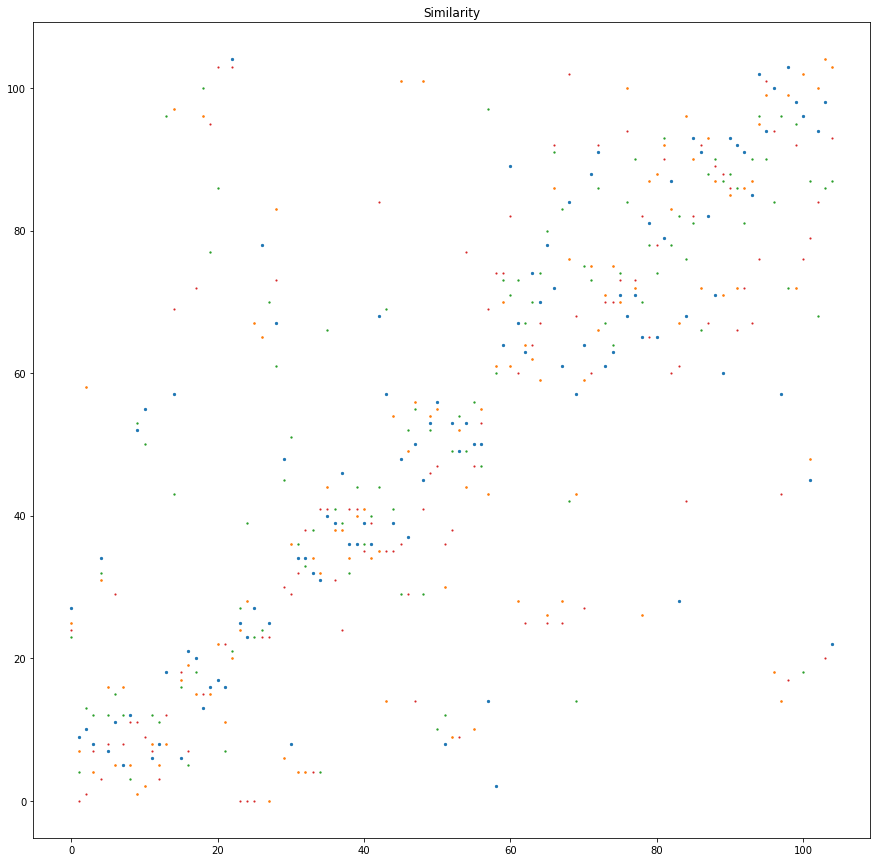

In [100]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.arange(105)
for i in range(1,5):
    y = np.array(indices[:,i])

    plt.scatter(x, y, s=5*(1/i))
#plt.scatter(dist_std_first,dist_std_first)
plt.title('Similarity')
plt.show()

# <a id='extract_info'>Extract output information</a>

## Energy

### sp

In [4]:
energies_sp = []
gap_sp = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/sp/CaMgO_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_sp.append(crystal_output.get_final_energy())
        gap_sp.append(crystal_output.get_band_gap())
        structuress.append(i)

In [66]:
# SAVE
import csv

with open('./data/crystal/sp/energies_sp.csv', 'w') as f:
      
    write = csv.writer(f)
      
    write.writerow(energies_sp)

In [95]:
# READ
with open('./data/crystal/sp/energies_sp.csv') as file:
      
    energies_sp = [float(x) for x in list(csv.reader(file))[0]]
      

### Cell

In [51]:
energies_cell = []
gap_cell = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/cell/CaMgO_cell_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_cell.append(crystal_output.get_final_energy())
        gap_cell.append(crystal_output.get_band_gap())
        structuress.append(i)

### Full opt

## Gap

In [55]:
energies = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/sp/CaMgO_sp_%s.out'%str(i))
    if crystal_output.get_band_gap() != None:
        energies.append(crystal_output.get_band_gap())
        structuress.append(i)

# <a id='geometry_opt'>Geometry optimisation</a>

### CaMgO

In [8]:
import re
structure_numbers_cry = []
directory = './data/crystal/full_out/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".out"):
        crystal_out = Crystal_output().read_cry_output(f)
        for line in crystal_out.data[::-1]:
            if 'OPT END - CONVERGED' in line:
                structure_numbers_cry.extend(re.findall(r'_(\d+)', f))
                print(crystal_out.get_final_energy())
                break
structure_numbers = [int(x) for x in structure_numbers_cry]
structure_numbers = sorted(structure_numbers)


-436228.7553230027
-436228.569243108
-436228.53426042193
-436228.7671577787
-436228.7194603004
-436228.7257975601
-436228.75116047694
-436228.7508562536
-436228.7824979257
-436228.6369047641
-436228.6469925692
-436228.7089175209
-436228.7733184366
-436228.6187144966
-436228.6833246679
-436228.6703739529
-436228.60892547254
-436228.73581189447
-436228.7365123156
-436228.5958702658
-436228.6529804347
-436228.7101746869
-436228.7266185276
-436228.65129931533
-436228.62778622855
-436228.486982271
-436228.7526108438
-436228.7876835995
-436228.6141013503
-436228.79520754784
-436228.73304286384
-436228.68235458195
-436228.78266881313
-436228.7006316538
-436228.72944851185
-436228.6599223315
-436228.5924389099
-436228.77890656685
-436228.711548862
-436228.5933488587
-436228.71925948036
-436228.63092016394
-436228.6902973135
-436228.7027636659
-436228.6965123941
-436228.71087320324
-436228.5988975325
-436228.6985845412
-436228.5598149069
-436228.5964460587
-436228.68569940556
-436228.6323155638

In [17]:
directory = './data/crystal/testgeom_opt/'
optimised_structures = []
non_optimised_structures = []

#non_optimised_structures
for structure_n in structure_numbers:
    filename = directory+'CaMgO_testgeom_%s.gui'%structure_n
    crystal_gui = Crystal_gui().read_cry_gui(filename)
    optimised_structures.append(cry_gui2pmg(crystal_gui))
    
    
    filename_2 = './data/crystal/testgeom/CaMgO_testgeom_%s.gui'%structure_n
    #crystal_gui = Crystal_gui().read_cry_gui(filename_2)
    #non_optimised_structures.append(structures[structure_n])
    crystal_gui = Crystal_gui().read_cry_gui(filename_2)
    #vview(cry_gui2pmg(crystal_gui))
    non_optimised_structures.append(cry_gui2pmg(crystal_gui))

#optimised_structures
#ROUND 1/3
for j in range(len(optimised_structures)):
    for i in range(structures[0].num_sites):

        delta = optimised_structures[j].frac_coords[i]-non_optimised_structures[j].frac_coords[i]

        shift = np.round(delta / (1/3)) * (1/3)

        optimised_structures[j].translate_sites([i],(-shift),to_unit_cell=False,frac_coords=True)

In [11]:
all_atomic_numbers = []
for i,structure in enumerate(structures):
    all_atomic_numbers.append(structure.atomic_numbers)
all_atomic_numbers = np.array(all_atomic_numbers)

In [14]:
vview(optimised_structures[0])

In [68]:
delta_vectors = []
delta_angle = []
delta_coords = []
a_i = non_optimised_structures[0].lattice.a
b_i = non_optimised_structures[0].lattice.b
c_i = non_optimised_structures[0].lattice.c

alpha_i = non_optimised_structures[0].lattice.alpha
beta_i = non_optimised_structures[0].lattice.beta
gamma_i = non_optimised_structures[0].lattice.gamma

for i in range(len(structure_numbers)):
    a_f, b_f, c_f =  optimised_structures[i].lattice.a, optimised_structures[i].lattice.b, optimised_structures[i].lattice.c
    alpha_f, beta_f, gamma_f =  optimised_structures[i].lattice.alpha, optimised_structures[i].lattice.beta, optimised_structures[i].lattice.gamma
    
    delta_vectors.append([a_f-a_i, b_f-b_i, c_f-c_i])
    delta_angle.append([alpha_f-alpha_i, beta_f-beta_i, gamma_f-gamma_i])
    delta_coords_tmp = optimised_structures[i].frac_coords - non_optimised_structures[i].frac_coords
    delta_coords_tmp += (delta_coords_tmp <-1.)*1
    delta_coords.append(delta_coords_tmp)
    
    delta = optimised_structures[i].frac_coords-non_optimised_structures[i].frac_coords
    print(np.max(np.abs(delta_coords_tmp)))
    
delta_vectors = np.array(delta_vectors)
delta_angle = np.array(delta_angle)
delta_coords = np.array(delta_coords)

0.018385088920075954
0.02048767087846351
0.02062802132870528
0.020773153279675022
0.021456017060468346
0.021469648196006885
0.02078265290710221
0.022162503655550836
0.020721601584196614
0.02288984814842293
0.020181878401413583
0.02588355252945787
0.024009830427750067
0.020341135348892286
0.02146217470544881
0.025522654080880336
0.020528442933712088
0.01973561563980125
0.020413890250447514
0.02205286213523685
0.020737664677940637
0.020937047123116198
0.020854795608273746
0.021856352048182925
0.02098591170038161
0.02141490643375088
0.022460969595030522
0.021988009912164097
0.019987820831890463
0.021418820374157155
0.02431952413235061
0.022779035187468433
0.021849521075931494
0.020979859144373725
0.020666112722820346
0.02283079619484024
0.019836843356305423
0.020912011938056585
0.022039315590565794
0.02055372557593163
0.022458899932910115
0.02197640983563695
0.02325814743683388
0.021321115688756387
0.019675019959247975
0.021962134509888875
0.023150990653481196
0.02149215653391906
0.020635

In [83]:
#mgcao
atomic_species = [20,8,12]

Ca_descriptors = []
O_descriptors = []
Mg_descriptors = []

Ca_displacement = []
O_displacement = []
Mg_displacement = []


for j,i in enumerate(structure_numbers): #i is the number among all and j is the number of the limited set
    #print(j,i)
    #for atom in atomic_species:
    atomic_numbers = np.array(non_optimised_structures[j].atomic_numbers)
    #print(atomic_numbers)
    for k,site in enumerate(atomic_numbers):
        #print(atomic_numbers)
        if site == [20]:
            Ca_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
            Ca_displacement.append(delta_coords[j,k])
        elif site == [8]:
            #print(atom,site)
            O_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
            O_displacement.append(delta_coords[j,k])
        if site == [12]:
            Mg_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
            Mg_displacement.append(delta_coords[j,k])

Ca_descriptors = np.array(Ca_descriptors)
O_descriptors = np.array(O_descriptors)
Mg_descriptors = np.array(Mg_descriptors)

Ca_displacement = np.array(Ca_displacement)
O_displacement = np.array(O_displacement)
Mg_displacement = np.array(Mg_displacement)

In [73]:
np.unique(O_descriptors,axis=0,return_counts=True,return_index=True)

(array([[ 8,  8,  8, ..., 12, 20, 20],
        [ 8,  8,  8, ..., 20, 12, 20],
        [ 8,  8,  8, ..., 12, 20, 12],
        ...,
        [ 8,  8,  8, ..., 12, 12, 12],
        [ 8,  8,  8, ..., 12, 12, 12],
        [ 8,  8,  8, ..., 12, 12, 12]]),
 array([1863, 3726,  837, ..., 2987,  161, 3581]),
 array([1, 1, 4, ..., 1, 3, 1]))

In [113]:
O_unique, O_first, O_count = np.unique(O_descriptors,axis=0,return_counts=True,return_index=True)
delta_unique = []
for i in O_unique:
    where = np.where((O_descriptors == i).all(axis=1))[0]
    delta_unique.append([np.average(O_displacement[where,i]) for i in range(3)])  
    print([np.round(np.average(O_displacement[where,i]),4) for i in range(3)])
    #print([np.std(O_displacement[where,i]) for i in range(3)])
delta_unique = np.array(delta_unique)

[-0.0148, 0.0173, -0.0013]
[0.0002, -0.0001, -0.0001]
[-0.0068, 0.01, 0.0003]
[-0.013, 0.014, -0.0005]
[-0.0043, -0.005, 0.0058]
[-0.003, -0.002, 0.0028]
[-0.0045, -0.0038, 0.004]
[-0.0052, -0.0035, 0.0043]
[-0.0049, -0.0049, 0.0052]
[-0.0043, -0.0038, 0.0043]
[-0.0123, 0.0037, 0.0119]
[0.0073, -0.0217, 0.0073]
[-0.0011, -0.0003, 0.0004]
[-0.0107, 0.0008, 0.0118]
[-0.0061, -0.0062, 0.0055]
[-0.0061, -0.0061, 0.0191]
[-0.0123, 0.0029, 0.0114]
[-0.0115, 0.003, 0.012]
[0.0125, -0.0129, -0.0002]
[0.0212, -0.0056, -0.0091]
[-0.0095, 0.0119, -0.0049]
[0.0122, -0.013, 0.0023]
[0.0167, 0.0002, -0.0105]
[0.0197, -0.0052, -0.0073]
[-0.0106, 0.0008, 0.0007]
[-0.011, 0.0131, -0.0011]
[-0.0115, 0.012, -0.0002]
[-0.0111, 0.0056, 0.0084]
[0.0049, -0.0202, 0.008]
[-0.0063, -0.0056, 0.006]
[0.0001, -0.0004, 0.0002]
[-0.0118, 0.0033, 0.0118]
[-0.0123, 0.0055, 0.0124]
[-0.0144, 0.0033, 0.0149]
[-0.0024, -0.0025, 0.0025]
[-0.0058, -0.0235, 0.0081]
[0.0003, -0.0059, 0.0081]
[0.0036, -0.0191, 0.0103]
[0.013

[0.008, 0.0071, 0.0073]
[0.0089, 0.0068, -0.0235]
[-0.0039, 0.008, 0.0015]
[-0.0033, 0.0094, 0.0044]
[-0.0033, 0.0039, 0.0105]
[-0.0055, 0.0046, -0.0062]
[-0.0089, -0.0089, 0.0098]
[-0.0142, -0.0042, 0.004]
[-0.0154, 0.0139, 0.0008]
[-0.0007, -0.0007, -0.0148]
[-0.0018, -0.0018, 0.0155]
[-0.0132, -0.002, 0.0134]
[-0.0063, 0.0021, -0.0014]
[-0.0123, -0.0046, 0.0035]
[-0.0081, 0.0232, -0.0098]
[-0.0089, -0.0089, 0.0094]
[-0.0159, -0.0008, 0.005]
[-0.0134, -0.0015, 0.0136]
[-0.0206, -0.0187, 0.0196]
[-0.0137, 0.0137, -0.0004]
[-0.0131, 0.0057, 0.0065]
[-0.0127, -0.0016, 0.013]
[-0.0072, 0.0068, 0.0068]
[-0.0153, 0.0004, 0.0004]
[-0.0147, 0.002, 0.0033]
[-0.0144, -0.0014, 0.001]
[-0.0017, 0.0038, -0.0045]
[-0.0129, 0.0132, -0.0008]
[0.0156, 0.0004, -0.0136]
[0.0222, -0.0072, -0.0072]
[-0.0141, -0.0033, 0.0149]
[0.0007, -0.0001, -0.0002]
[-0.0066, -0.0063, 0.0064]
[-0.0089, -0.0089, 0.008]
[-0.0154, 0.0005, -0.0016]
[0.0078, 0.0075, -0.0219]
[-0.001, 0.0042, 0.0001]
[0.0103, 0.0003, 0.0005]

[0.0052, 0.005, -0.0047]
[0.0103, 0.0086, -0.0094]
[0.0072, 0.0072, -0.0072]
[0.0115, -0.0012, 0.0009]
[0.0111, -0.0105, -0.0017]
[0.0224, -0.0064, -0.008]
[0.0138, -0.0014, 0.0017]
[0.0133, -0.0131, -0.0001]
[0.0088, -0.0007, 0.0012]
[0.0219, -0.007, -0.007]
[0.0159, -0.0065, -0.0028]
[0.0156, -0.0053, -0.0048]
[0.0068, -0.006, 0.006]
[0.0158, 0.0005, -0.0152]
[0.0112, 0.0009, -0.0111]
[0.0145, -0.0137, -0.0004]
[0.0112, -0.0066, -0.0019]
[0.009, -0.0075, 0.0087]
[0.0132, -0.0131, 0.0]
[0.0056, -0.0048, 0.0052]
[0.0131, -0.0063, -0.0009]
[0.0149, -0.0, -0.0153]
[0.0123, 0.0006, -0.0004]
[0.0154, 0.002, -0.0093]
[0.0117, 0.0013, -0.0126]
[0.0185, -0.002, -0.0118]
[0.0117, 0.0059, -0.0051]
[0.0042, -0.0052, 0.0015]
[0.0043, 0.0044, -0.0043]
[0.0005, -0.0005, -0.0002]
[-0.006, 0.0054, 0.0068]
[-0.0007, -0.0001, 0.0003]
[-0.0018, 0.0006, 0.0006]
[0.0055, 0.0014, -0.001]
[0.0071, 0.0068, -0.007]
[0.014, 0.0116, -0.0128]
[0.0072, -0.001, -0.0124]
[0.008, -0.0077, 0.0074]
[0.0053, 0.0044, -0

In [111]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(O_unique, delta_unique[:,1],test_size=0.2)

'''#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) '''

for i in range(2,10):    
    print()
    print(i)
        
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train,y_train)
    
    predictions_train_LR = model.predict(X_train)
    
    train_error_LR= np.sqrt(mean_squared_error(y_train, predictions_train_LR))
    print('Train Error:',train_error_LR)
    #Test Error
    predictions_test_LR = model.predict(X_test)
    test_error_LR= np.sqrt(mean_squared_error(y_test, predictions_test_LR))
    print('Test Error:', test_error_LR)
    #evaluate the R^2
    score_LR=model.score(X_train, y_train) #returns the R^2 score
    print('R^2 returned by the KNeighborsRegressor:',score_LR)
    
    
    


2
Train Error: 0.004942067396139132
Test Error: 0.008593111625690177
R^2 returned by the KNeighborsRegressor: 0.6360074212928661

3
Train Error: 0.005712780056413885
Test Error: 0.008252753432273966
R^2 returned by the KNeighborsRegressor: 0.5136261582573343

4
Train Error: 0.006066510385804685
Test Error: 0.00800138965402927
R^2 returned by the KNeighborsRegressor: 0.45152972857552875

5
Train Error: 0.006292276378388387
Test Error: 0.00773571316346353
R^2 returned by the KNeighborsRegressor: 0.40994732730977823

6
Train Error: 0.0064177162729712875
Test Error: 0.007597921007399575
R^2 returned by the KNeighborsRegressor: 0.38618679414743395

7
Train Error: 0.006544487211294963
Test Error: 0.007510862833683437
R^2 returned by the KNeighborsRegressor: 0.3616976424508057

8
Train Error: 0.006645433553891416
Test Error: 0.007417943473639853
R^2 returned by the KNeighborsRegressor: 0.3418546130006115

9
Train Error: 0.0067128615755410355
Test Error: 0.007457415392213358
R^2 returned by t

### LTS

In [28]:
#lts
atomic_species = [3,16,22]

Li_descriptors = []
S_descriptors = []
Ti_descriptors = []

Li_displacement = []
S_displacement = []
Ti_displacement = []


for j,i in enumerate(structure_numbers):
    #print(j,i)
    for atom in atomic_species:
        atomic_numbers = np.array(non_optimised_structures[j].atomic_numbers)
        #print(atomic_numbers)
        for k,site in enumerate(atomic_numbers):
            if site == [3]:
                Li_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
                Li_displacement.append(delta_coords[j,k])
            elif site == [16]:
                S_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
                S_displacement.append(delta_coords[j,k])
            if site == [22]:
                Ti_descriptors.append(neighbours_spatial_dist_all_sorted_sliced[i,k])
                Ti_displacement.append(delta_coords[j,k])
            #print(atom,neighbours_spatial_dist_all_sorted_sliced[i,site])

# Cluster analysis

In [35]:
for structure in structure_numbers:
    print(descriptor_4[structure])

NameError: name 'descriptor_4' is not defined

In [89]:
neighbours_spatial_dist_all_sorted_sliced[1][-1]

array([ 8,  8,  8,  8,  8,  8, 20, 20, 20, 12, 20, 12, 20, 12, 20, 12, 12,
       12,  8,  8,  8,  8,  8,  8,  8,  8, 12, 12, 12, 12, 12, 12])

# <a id='functions'>The functions</a>

In [3]:
def build_discrete_vector(x,num_species=None):
    x = np.array(x)
    unique_species = np.unique(x)

    if num_species == None:
        num_species = len(unique_species)
        
    x_binary = np.array([0]*len(x)*num_species)
    
    for i,atom in enumerate(unique_species):
        position = np.where(x == atom)[0]
        x_binary[position*num_species+i] = 1

    return x_binary

def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))
    
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(r,6), round(el,6), round(az,6) ]

def cart2sph_array(array):
    sph_coordinates = []
    for line in array:
        x = line[0]
        y = line[1]
        z = line[2]
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        if np.around(az,6) ==  np.around(2*np.pi,6) \
        or np.around(az,6) ==  -np.around(2*np.pi,6):
            az = 0.
        if np.around(az,6) < 0.:
            az = np.round(2*np.pi+az,6)
        sph_coordinates.append([round(r,6), round(el,6), round(az,6) ])   
    return sph_coordinates

# THE END

## Selected structures

In [100]:
space_groups_dict

{1: array([   5,    6,    7, ..., 4010, 4011, 4012]),
 2: array([  15,   42,   48, 2084, 2130, 2161, 2181, 2194, 2328, 2337, 2671,
        2703, 2716, 2738, 2749, 3417]),
 5: array([  17,   41,   49,  152,  185,  305,  315,  318,  327,  341,  417,
         450,  502,  593,  734,  744,  757,  762,  768,  773,  778,  877,
         919,  950,  973, 1010, 1089, 1280, 1430, 1483, 1485, 1582, 1684,
        1689, 1705, 1751, 1808, 1901, 1962, 1972, 1989, 2006, 2029, 2055,
        2061, 2078, 2097, 2127, 2139, 2145, 2190, 2193, 2199, 2202, 2240,
        2265, 2270, 2298, 2306, 2327, 2336, 2344, 2485, 2509, 2510, 2567,
        2574, 2576, 2654, 2672, 2718, 2724, 2729, 2748, 2782, 2788, 2794,
        2805, 2807, 2830, 2835, 2849, 2851, 2855, 2862, 2866, 2934, 2947,
        2963, 2978, 2981, 3077, 3088, 3100, 3109, 3112, 3119, 3169, 3187,
        3211, 3212, 3246, 3247, 3257, 3270, 3276, 3286, 3296, 3299, 3321,
        3369, 3412, 3453, 3456, 3458, 3500, 3522, 3557, 3558, 3566, 3592,
        3616

In [103]:
crystal_input = Crystal_input('data/classification/ml/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

select_structures = [3862,5]    
for structure in select_structures:
    
    write_crystal_gui('data/classification/ml/cao_%s_PBE.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/cao_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP cao_%s_PBE'%structure)
    with open('data/classification/ml/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## Small_set

In [53]:
crystal_input = Crystal_input('data/classification/ml/small_set/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

for structure in range(len(structures)):
    
    write_crystal_gui('data/classification/ml/small_set/cao_%s_B3LYP.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/small_set/cao_%s_B3LYP.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP cao_%s_B3LYP'%structure)
    with open('data/classification/ml/small_set/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    print('qsub %s.qsub'%structure)
    

qsub 0.qsub
qsub 1.qsub
qsub 2.qsub
qsub 3.qsub
qsub 4.qsub
qsub 5.qsub
qsub 6.qsub
qsub 7.qsub
qsub 8.qsub
qsub 9.qsub
qsub 10.qsub
qsub 11.qsub
qsub 12.qsub
qsub 13.qsub
qsub 14.qsub
qsub 15.qsub
qsub 16.qsub
qsub 17.qsub
qsub 18.qsub
qsub 19.qsub
qsub 20.qsub
qsub 21.qsub
qsub 22.qsub
qsub 23.qsub
qsub 24.qsub
qsub 25.qsub
qsub 26.qsub
qsub 27.qsub
qsub 28.qsub
qsub 29.qsub
qsub 30.qsub
qsub 31.qsub
qsub 32.qsub
qsub 33.qsub
qsub 34.qsub
qsub 35.qsub
qsub 36.qsub
qsub 37.qsub
qsub 38.qsub
qsub 39.qsub
qsub 40.qsub
qsub 41.qsub
qsub 42.qsub
qsub 43.qsub
qsub 44.qsub
qsub 45.qsub
qsub 46.qsub
qsub 47.qsub
qsub 48.qsub
qsub 49.qsub
qsub 50.qsub
qsub 51.qsub
qsub 52.qsub
qsub 53.qsub
qsub 54.qsub
qsub 55.qsub
qsub 56.qsub
qsub 57.qsub
qsub 58.qsub
qsub 59.qsub
qsub 60.qsub
qsub 61.qsub
qsub 62.qsub
qsub 63.qsub
qsub 64.qsub
qsub 65.qsub
qsub 66.qsub
qsub 67.qsub
qsub 68.qsub
qsub 69.qsub
qsub 70.qsub
qsub 71.qsub
qsub 72.qsub
qsub 73.qsub
qsub 74.qsub
qsub 75.qsub
qsub 76.qsub
qsub 77.q

## One per space group in reverse

In [ ]:
crystal_input = Crystal_input('data/classification/ml/pseudo_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

    
for structure in reversed(np.unique(space_groups,return_counts=True, return_index=True)[1]):
    
    write_crystal_gui('data/classification/ml/pseudo/LTS_%s_PBE.gui'%structure,structures[structure],pseudo_atoms=[22])
    write_crystal_input('data/classification/ml/pseudo/LTS_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE'%structure)
    with open('data/classification/ml/pseudo/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## All space groups organised in folders

In [27]:
crystal_input = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

for space_group in reversed(space_groups_unique[-12:]):
    #print(len(space_groups_dict[space_group]))
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%space_group

    Path('data/classification/ml/sg_%s'%space_group).mkdir(parents=True, exist_ok=True)
    for structures_n in space_groups_dict[space_group]:
        crystal_input.scf_block[0][1] = '%s %s \n'%(shrink[structures_n], shrink[structures_n]*2)
        write_crystal_gui('data/classification/ml/sg_%s/LTS_%s_PBE.gui'%(space_group,structures_n),structures[structures_n])
        write_crystal_input('data/classification/ml/sg_%s/LTS_%s_PBE.d12'%(space_group,structures_n),crystal_input=crystal_input)
        
        queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE\n'%structures_n)
    with open('data/classification/ml/sg_%s/sg_%s.qsub'%(space_group,space_group), 'w') as file:
        file.writelines(queue)
    print('cd sg_%s'%space_group)
    print('qsub sg_%s.qsub'%space_group)
    print('cd ..')

cd sg_225
qsub sg_225.qsub
cd ..
cd sg_166
qsub sg_166.qsub
cd ..
cd sg_164
qsub sg_164.qsub
cd ..
cd sg_160
qsub sg_160.qsub
cd ..
cd sg_155
qsub sg_155.qsub
cd ..
cd sg_151
qsub sg_151.qsub
cd ..
cd sg_146
qsub sg_146.qsub
cd ..
cd sg_139
qsub sg_139.qsub
cd ..
cd sg_121
qsub sg_121.qsub
cd ..
cd sg_119
qsub sg_119.qsub
cd ..
cd sg_107
qsub sg_107.qsub
cd ..
cd sg_82
qsub sg_82.qsub
cd ..


## Analyse the structures

In [15]:
import sys
sys.path.insert(1,'../../crystal-code-tools/CRYSTALpy/CRYSTALpy/')
from convert import cry_gui2pmg

initial_positions = structures[0].cart_coords
initial_cell = structures[0].lattice.matrix
structure_id = []
not_converged = []
energy = []
all_disp = []
output_folder = "data/classification/ml/outputs_optgeom/"
for file in os.listdir(output_folder):
    if file.endswith(".out"):
        structure_n = int(file.split('_')[1])
        output = Crystal_output(os.path.join(output_folder, file))
        if output.converged == True:
            structure_id.append(structure_n)
            #print(os.path.join("data/classification/ml/outputs_optgeom/", file[0:14]))

            energy.append(output.get_final_energy())
            last_geom = sorted(os.listdir(os.path.join(output_folder,"LTS_%s_PBE.optstory"%structure_n)))[-1]
            pmg_structure = cry_gui2pmg(os.path.join(output_folder,"LTS_%s_PBE.optstory/%s"%(structure_n,last_geom)))
            pmg_structure.lattice
            disp_atoms = pmg_structure.cart_coords - initial_positions
            disp_cell = pmg_structure.lattice.matrix - initial_cell
            all_disp.append(np.concatenate((disp_cell,disp_atoms),axis=0))
        else:
            not_converged.append(structure_n)


In [14]:
all_disp

[array([[ 0.00000000e+00, -1.61139691e-01, -1.61139691e-01],
        [-1.61139691e-01,  0.00000000e+00, -1.61139691e-01],
        [-1.61139691e-01, -1.61139691e-01,  0.00000000e+00],
        [-8.54427185e-02,  2.33078659e-18,  2.33078659e-18],
        [ 9.78926259e-02, -2.05319086e-01, -6.74323956e-18],
        [ 5.37132302e-02,  1.39155949e-01,  2.87965275e-18],
        [ 9.78926259e-02, -6.74323956e-18, -2.05319086e-01],
        [-1.07426460e-01, -2.05319086e-01, -2.05319086e-01],
        [-8.04660200e-02,  1.34179250e-01, -1.34179250e-01],
        [ 5.37132302e-02,  2.87965275e-18,  1.39155949e-01],
        [-8.04660200e-02, -1.34179250e-01,  1.34179250e-01],
        [ 1.87892480e-01,  1.34179250e-01,  1.34179250e-01],
        [-8.04660200e-02, -1.34179250e-01, -1.34179250e-01],
        [ 2.67527897e-02, -2.69604405e-02, -1.34179250e-01],
        [ 5.37132302e-02, -1.51382065e-17, -1.39155949e-01],
        [ 2.67527897e-02, -1.34179250e-01, -2.69604405e-02],
        [-1.07426460e-01

### Structural analysis (like LTS)

In [64]:
average_mg = []
std_average_mg = []
average_std_mg_combined = []
for n,structure in enumerate(structures):
    average = 0.
    std_average = []
    for i in mg_atoms[n]:
        for j in mg_atoms[n]: 
            if i != j:
                average += round(structure.sites[i].distance(structure.sites[j]),6)
                std_average.append(structure.sites[i].distance(structure.sites[j]))
    average_mg.append(average/((len(mg_atoms[n]))*(len(mg_atoms[n])-1)))
    std_average_mg.append(np.std(std_average))
    average_std_mg_combined.append([average/(len(mg_atoms[n])**2),np.std(std_average)])

In [65]:
unique_mg_average = np.unique(np.sort(np.array(average_mg)),axis=0)
average_mg_group = []
for i in range(len(structures)):
    average_mg_group.append(np.where(unique_mg_average == average_mg[i])[0][0])

In [67]:
dist_std_unique, dist_std_first, dist_std_occ =  \
np.unique(np.round(np.array(average_std_mg_combined),6),axis=0,return_counts=True,return_index=True)

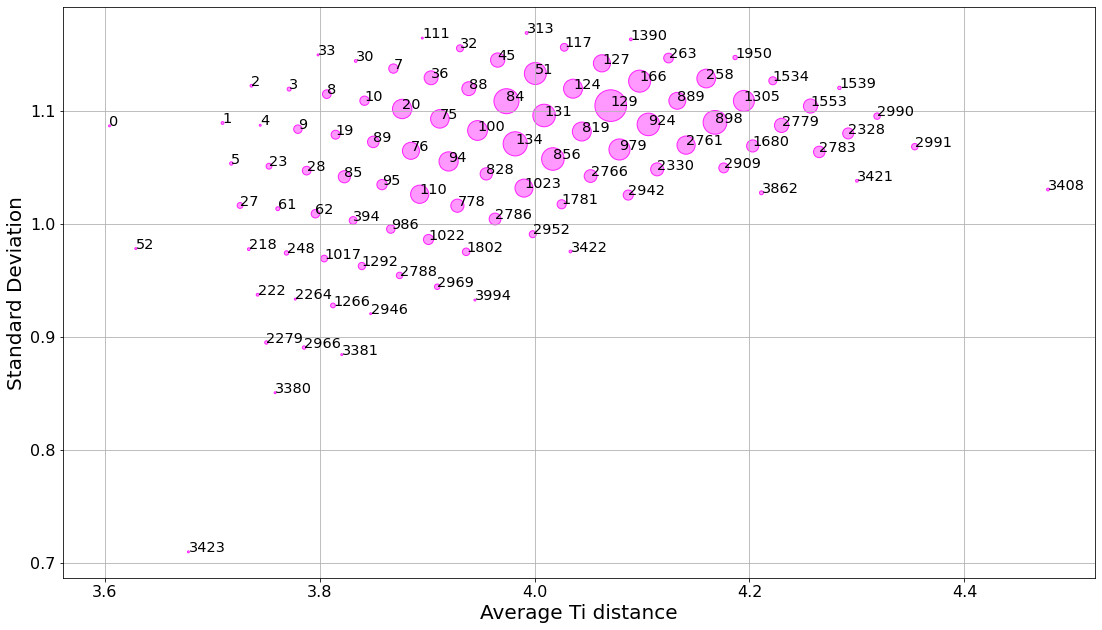

In [69]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

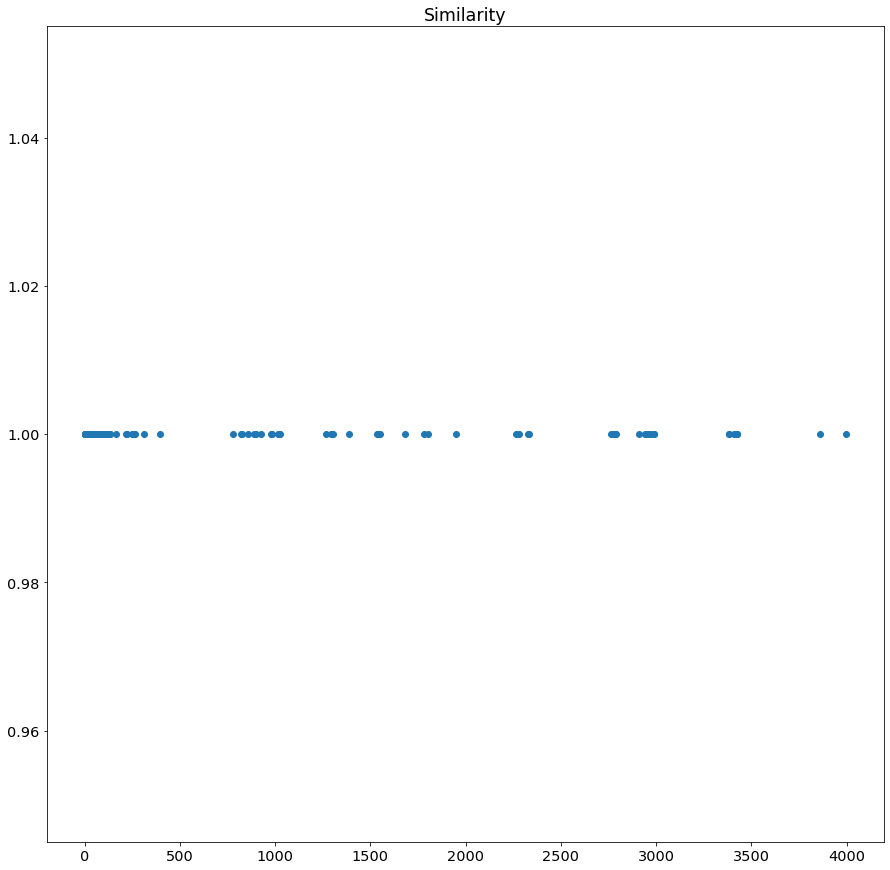

In [70]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.array(dist_std_first)

y = [1]*len(x)

plt.scatter(x, y)
plt.title('Similarity')
plt.show()

# THE END

### SHRINK test

In [ ]:
struct = cry_gui2pmg('data/classification/ml/optc021')
inp = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

energy = []
for i in range(4,13):

    energy.append(Crystal_output('data/classification/ml/test_shrink/LTS_%s.out'%i).get_final_energy())

In [ ]:
for j,i in enumerate(energy[1:]):
    print(energy[j]-energy[j+1])

# TESTING

## THIS ONE WORKS (it scales better when a large number of shells is included)
It doesn't work for the primitive cell

In [ ]:
atom_type_1max_shell = 2
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
for k,structure in enumerate(structures[100:105]):
    print('STRUCTURE',structure)
    time0 = time.time()
    neighbours_spatial_dist = []
    for j in range(structure.num_sites):
        centered_sph_coords = []
        for i in range(structure.num_sites):  
            print(i,j)
            translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
            new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
            #print(translation_vector)
            #print(new_cart_coords,structure.cart_coords[i])
            centered_cart_coords = new_cart_coords-structure.cart_coords[j] 
            centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        
            #print(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))
        #centered_sph_coords_all.append(centered_sph_coords)
        centered_sph_coords = np.array(centered_sph_coords)
        #print(centered_sph_coords)

        atoms_shell = []
        for unique in shells:
            atoms_shell.append(np.where(np.round(centered_sph_coords[:,2],5) == np.round(unique,5))[0].tolist())
            
        #print(atoms_shell)
        neighbours_spatial_dist_atom = []
        for shell in range(max_shell+1):
            #a = np.array(centered_sph_coords)[atoms_shell[shell]]
            spatial_distribution = np.argsort(centered_sph_coords[atoms_shell[shell]][:,1]*10 + centered_sph_coords[atoms_shell[shell]][:,0])
            #print(np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]])
            #print(np.array(atoms_shell[shell])[spatial_distribution])
            
            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]]).tolist())
            #THIS IS THE CONTROL LINE
            #print(centered_sph_coords[np.array(atoms_shell[shell])[spatial_distribution]])
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist)
    print(time.time()-time0)
    #centered_sph_coords_structure = np.array(centered_sph_coords_all)


In [4]:
def get_config_analysis_test(self):
        # Return the configuration analysis for solid solutions (CONFCON keyword in input)

        import re
        import numpy as np

        # Check this is a configuration analysis calculation
        try:
            begin = self.data.index(
                '                             CONFIGURATION ANALYSIS\n')
        except:
            return "WARNING: this is not a CONFCNT analysis."
        
        for line in self.data[::-1]:
            if '----' in line:
                dash_line = line.rstrip().lstrip()
                #print(line.rstrip(),len(line.rstrip()))
                break
        #print(dash_line)
                
        for i, line in enumerate(self.data[begin:]):
            if re.match(r'^ COMPOSITION', line):
                self.n_classes = line.split()[9]
                original_atom = str(line.split()[2])
                begin = begin+i
        config_list = []

        # Read all the configurations
        for line in self.data[begin:]:
            if not re.match(r'^   WARNING', line):
                config_list.extend(line.split())
        config_list = np.array(config_list)
        warning = np.where(config_list == 'WARNING')
        config_list = np.delete(config_list, warning)
        atom1_begin = np.where(config_list == original_atom)[0]
        atom1_end = np.where(
            config_list == dash_line)[0]
        atom2_begin = np.where(config_list == 'XX')[0]
        atom2_end = np.where(
            config_list == '<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')[0]
        end = np.where(
            config_list == '===============================================================================')[0][-1]
        atom2_end = np.append(atom2_end, end)
        atom_type1 = []
        atom_type2 = []
        config_list = config_list.tolist()
        for i in range(len(atom1_end)):
            atom_type1.append(
                [int(x) for x in config_list[atom1_begin[i+1]+1:atom1_end[i]]])
            atom_type2.append(
                [int(x) for x in config_list[atom2_begin[i]+1:atom2_end[i]]])

        self.atom_type1 = atom_type1
        self.atom_type2 = atom_type2
        print(atom1_end)
        return [self.atom_type1, self.atom_type2]
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount_2.out')
get_config_analysis_test(cry_output)

[ 28  52  76 100]


[[[5, 6, 7, 8], [4, 6, 7, 8], [4, 5, 7, 8], [3, 4, 5, 6]],
 [[1, 2, 3, 4], [1, 2, 3, 5], [1, 2, 3, 6], [1, 2, 7, 8]]]

In [21]:
for line in cry_output.data[::-1]:
    if '----' in line:
        dash_line = '-'*len(line)
        break
print(dash_line)

---------------------------------------------------------------------------------


In [348]:
#WIP
max_shell = 1
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures[0:1]): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        neighbours = []
        
        for n in range(1,max_shell+1):
            #print(Element(structure.get_neighbors_in_shell(structure.cart_coords[j],np.round(shells[n],2),0.5)))#.as_dict(verbosity=1)['species'][0]['element']).number)
            neighboursstructure.get_neighbors_in_shell(structure.cart_coords[j],np.round(shells[n],6),0.5))
            print()
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:

                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,0])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)    
neighbours_spatial_dist_all

0 [PeriodicSite: O (-2.4191, -0.0000, 0.0000) [0.1667, -0.1667, -0.1667], PeriodicSite: O (-0.0000, -2.4191, -0.0000) [-0.1667, 0.1667, -0.1667], PeriodicSite: O (0.0000, 0.0000, -2.4191) [-0.1667, -0.1667, 0.1667], PeriodicSite: O (-0.0000, -0.0000, 2.4191) [0.1667, 0.1667, -0.1667], PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.1667, -0.1667, 0.1667], PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.1667, 0.1667, 0.1667]]

1 [PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.1667, -0.1667, 0.1667], PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.1667, 0.1667, 0.1667], PeriodicSite: O (2.4191, 2.4191, -2.4191) [-0.1667, -0.1667, 0.5000], PeriodicSite: O (2.4191, 2.4191, 2.4191) [0.1667, 0.1667, 0.1667], PeriodicSite: O (2.4191, 4.8382, 0.0000) [0.1667, -0.1667, 0.5000], PeriodicSite: O (4.8382, 2.4191, 0.0000) [-0.1667, 0.1667, 0.5000]]

2 [PeriodicSite: O (-4.8382, -2.4191, 0.0000) [0.1667, -0.1667, -0.5000], PeriodicSite: O (-2.4191, -4.8382, 0.0000) [-0.1667, 0.1667, -0.5000], PeriodicSite: O (-2

[[[8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [20, 20, 12, 12, 12, 20],
  [20, 20, 12, 20, 12, 12],
  [20, 20, 12, 12, 12, 20],
  [12, 12, 20, 20, 12, 20],
  [20, 12, 20, 12, 20, 12],
  [12, 12, 20,

# Classification for Machine Learning

### Ideas:

### NEW:
- classify according to the descriptor
- extract info about opt
- do a few DFT calculations -> build ML potential -> build a binary model for QA 

#### Materials:
- CaMgO2 opt STO-3G
    - atoms only
    - whole cell
- CaSrO2 opt STO-3G

#### Energy
- run scf calculations on N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the corresponding energy
- get the energy of new structures from the NN using their descriptor neighbours_spatial_dist_all

#### Geometry optimisation:
- optimise the geometry of N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the displacement of the atoms in the structures. This would be a Mx3 (M = number of atoms) array that contains the x,y,z displacements.
- get the displacement of atoms for a new structure
- How do we include the cell? First line added to the neighbours_spatial_dist_all array of the structure (+ padding)?

#### Tests and questions
- How many shells to use?
- Using the non optimised energy vs using the optimised energy
- For the geometry optimisation part: does starting from a NN optimised structure make the full convergence quicker?
- Does training the NN with the optimised structure energies predict the energy of what the optimised geometry would give?
- Any difference in using fractional or cartesian displacements?

#### Info for the NN:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- energy: enegy of the optimised structures (list of J energy values, where J depends on how many calculations were performed)
- all_disp: information about the total displacement from the initial structures, cell and atoms (list of J 2d arrays (3 + N_atoms x 3), where J is the number of calculations that were run and the (3 + N_atoms are the cell parameters + the atom coordinates)
- disp_cell: information about the displacement from the initial cell (list of J 2d arrays (3 x 3), where J is the number of calculations that were run
- disp_atoms: information about the displacement of the atoms from the initial structures (list of J 2d arrays (N_atoms x 3), where J is the number of calculations that were run 

#### ML ideas:
- simple cosine similarity
- NN trained on 2D descriptors
- benchmark existing decriptors (https://singroup.github.io/dscribe/latest/tutorials/tutorials.html#)
- clustering vs regression
- geometry optimisation
- giving different weights to shells

#### Possible descriptors:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- neighbours_spatial_dist_all_sorted: like neighbours_spatial_dist_all, but storted row-sorted
- neighbours_spatial_dist_all_sorted_sliced: like neighbours_spatial_dist_all_sorted, but without the central atom number
- neighbours_spatial_dist_all_sorted_sliced_flat: like neighbours_spatial_dist_all_sorted, but without the central atom number, but as a flat array
- neighbours_spatial_dist_all_sorted_sliced_sum: like neighbours_spatial_dist_all_sorted_sliced, but summed columnwise
